# Backtesting trading strategies using `zipline` with LKTB `bundles`

## Importing libraries

In [ ]:
%load_ext watermark

In [2]:
%load_ext zipline

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # 그래프를 더 높은 해상도로 출력

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipline
from trading_calendars import get_calendar
# from yahoofinancials import YahooFinancials
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
%watermark --iversions

numpy   1.14.3
zipline v1.3.0
pandas  0.22.0



## Import custom data - LKTB futures

In [6]:
!zipline bundles

csvdir <no ingestions>
krx_futures 2020-03-25 05:23:40.981897
krx_futures 2020-03-25 05:22:42.884178
quandl 2020-02-14 02:32:04.287211
quandl 2020-02-14 02:30:18.481401
quandl 2020-02-14 02:29:44.742234
quandl 2020-02-14 02:29:22.007164
quandl 2020-02-14 02:27:14.838854
quandl 2020-02-13 04:26:16.333277
quandl 2020-02-13 04:18:29.688599
quantopian-quandl 2020-02-14 05:16:44.368675


`krx_futures` 라는 이름으로 custom bundle을 추가합니다. .zipline/extension.py 파일을 아래 코드와 같이 변경합니다.

In [ ]:
import pandas as pd

from zipline.data.bundles import register
from zipline.data.bundles.csvdir import csvdir_equities

start_session = pd.Timestamp('2012-01-02', tz='utc')
end_session = pd.Timestamp('2019-12-30', tz='utc')

# register the bundle
register(
    'krx_futures',  # name we select for the bundle
    csvdir_equities(
        # name of the directory as specified above (named after data frequency)
        ['daily'],
        # path to directory containing the
        './data',
    ),
    calendar_name='XKRX',  # Korea Exchange
    start_session=start_session,
    end_session=end_session

In [7]:
!zipline ingest --bundle krx_futures

Merging daily equity files:
Loading custom pricing data: 
 | lktb: sid 0


In [8]:
!zipline bundles

csvdir <no ingestions>
krx_futures 2020-03-25 08:08:04.871141
krx_futures 2020-03-25 05:23:40.981897
krx_futures 2020-03-25 05:22:42.884178
quandl 2020-02-14 02:32:04.287211
quandl 2020-02-14 02:30:18.481401
quandl 2020-02-14 02:29:44.742234
quandl 2020-02-14 02:29:22.007164
quandl 2020-02-14 02:27:14.838854
quandl 2020-02-13 04:26:16.333277
quandl 2020-02-13 04:18:29.688599
quantopian-quandl 2020-02-14 05:16:44.368675


## Strategies

### Buy And Hold Strategy

In [9]:
%%zipline --start 2019-1-2 --end 2019-12-30 --capital-base 10000 --bundle krx_futures -o buy_and_hold.pkl --trading-calendar XKRX

# imports
from zipline.api import order_percent, order, record, symbol, set_benchmark
from zipline.finance import commission

# parameters
SELECTED_STOCK = 'LKTB'
# n_stocks_to_buy = 10 # order_percent 로 변경하며 주석처리

def initialize(context):
    set_benchmark(symbol('LKTB'))
    context.asset = symbol(SELECTED_STOCK)
    context.has_ordered = False
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))

def handle_data(context, data):
    
    # trading logic
    if not context.has_ordered:
        # placing order, negative number for sale/short
        order_percent(context.asset, 1)
        # setting up a flag for holding a position
        context.has_ordered = True
        
    # record price for further inspection
    record(price=data.current(context.asset, 'price'))

algo_volatility  algorithm_period_return     alpha  \
2019-01-02 06:30:00+00:00              NaN                 0.000000       NaN   
2019-01-03 06:30:00+00:00         0.005588                -0.000498 -0.026416   
2019-01-04 06:30:00+00:00         0.004800                -0.001044 -0.045920   
2019-01-07 06:30:00+00:00         0.007619                -0.002214 -0.048828   
2019-01-08 06:30:00+00:00         0.008957                -0.003618 -0.043427   
2019-01-09 06:30:00+00:00         0.010793                -0.003228 -0.017156   
2019-01-10 06:30:00+00:00         0.016762                -0.001512  0.006100   
2019-01-11 06:30:00+00:00         0.018809                -0.003618  0.003087   
2019-01-14 06:30:00+00:00         0.024390                -0.000888  0.008623   
2019-01-15 06:30:00+00:00         0.023414                -0.000108  0.008579   
2019-01-16 06:30:00+00:00         0.022516                -0.000888  0.007113   
2019-01-17 06:30:00+00:00         0.021516                -0.001278  0.006213   
2019-01-18 06:30:00+00:00         0.024514                -0.004398  0.004630   
2019-01-21 06:30:00+00:00         0.023988                -0.005802  0.003845   
2019-01-22 06:30:00+00:00         0.026982                -0.002838  0.005001   
2019-01-23 06:30:00+00:00         0.026168                -0.002448  0.004801   
2019-01-24 06:30:00+00:00         0.025354                -0.002838  0.004411   
2019-01-25 06:30:00+00:00         0.024705                -0.003618  0.003977   
2019-01-28 06:30:00+00:00         0.024313                -0.004866  0.003514   
2019-01-29 06:30:00+00:00         0.024496                -0.006894  0.003042   
2019-01-30 06:30:00+00:00         0.023990                -0.007908  0.002736   
2019-01-31 06:30:00+00:00         0.028158                -0.003696  0.003555   
2019-02-01 06:30:00+00:00         0.027826                -0.002604  0.003546   
2019-02-07 06:30:00+00:00         0.027282                -0.003306  0.003315   
2019-02-08 06:30:00+00:00         0.027919                -0.000888  0.003482   
2019-02-11 06:30:00+00:00         0.028275                 0.001374  0.003597   
2019-02-12 06:30:00+00:00         0.028930                -0.001278  0.003207   
2019-02-13 06:30:00+00:00         0.028494                -0.002136  0.003021   
2019-02-14 06:30:00+00:00         0.028074                -0.001434  0.002975   
2019-02-15 06:30:00+00:00         0.027978                 0.000126  0.003003   
...                                    ...                      ...       ...   
2019-11-18 06:30:00+00:00         0.042033                 0.011896  0.000422   
2019-11-19 06:30:00+00:00         0.042195                 0.016350  0.000422   
2019-11-20 06:30:00+00:00         0.042437                 0.021498  0.000423   
2019-11-21 06:30:00+00:00         0.042356                 0.020484  0.000421   
2019-11-22 06:30:00+00:00         0.042284                 0.019228  0.000418   
2019-11-25 06:30:00+00:00         0.042274                 0.016740  0.000415   
2019-11-26 06:30:00+00:00         0.042232                 0.018846  0.000414   
2019-11-27 06:30:00+00:00         0.042238                 0.021732  0.000414   
2019-11-28 06:30:00+00:00         0.042143                 0.021732  0.000412   
2019-11-29 06:30:00+00:00         0.042118                 0.024150  0.000412   
2019-12-02 06:30:00+00:00         0.042435                 0.018534  0.000406   
2019-12-03 06:30:00+00:00         0.042453                 0.015648  0.000403   
2019-12-04 06:30:00+00:00         0.042963                 0.022668  0.000405   
2019-12-05 06:30:00+00:00         0.042871                 0.022434  0.000403   
2019-12-06 06:30:00+00:00         0.042850                 0.020094  0.000399   
2019-12-09 06:30:00+00:00         0.042819                 0.022434  0.000399   
2019-12-10 06:30:00+00:00         0.042761                 0.024228  0.000398   
2019-12-11 06:30:00+00:00         0.042674                

In [10]:
# read the performance summary dataframe
buy_and_hold_results = pd.read_pickle('buy_and_hold.pkl')

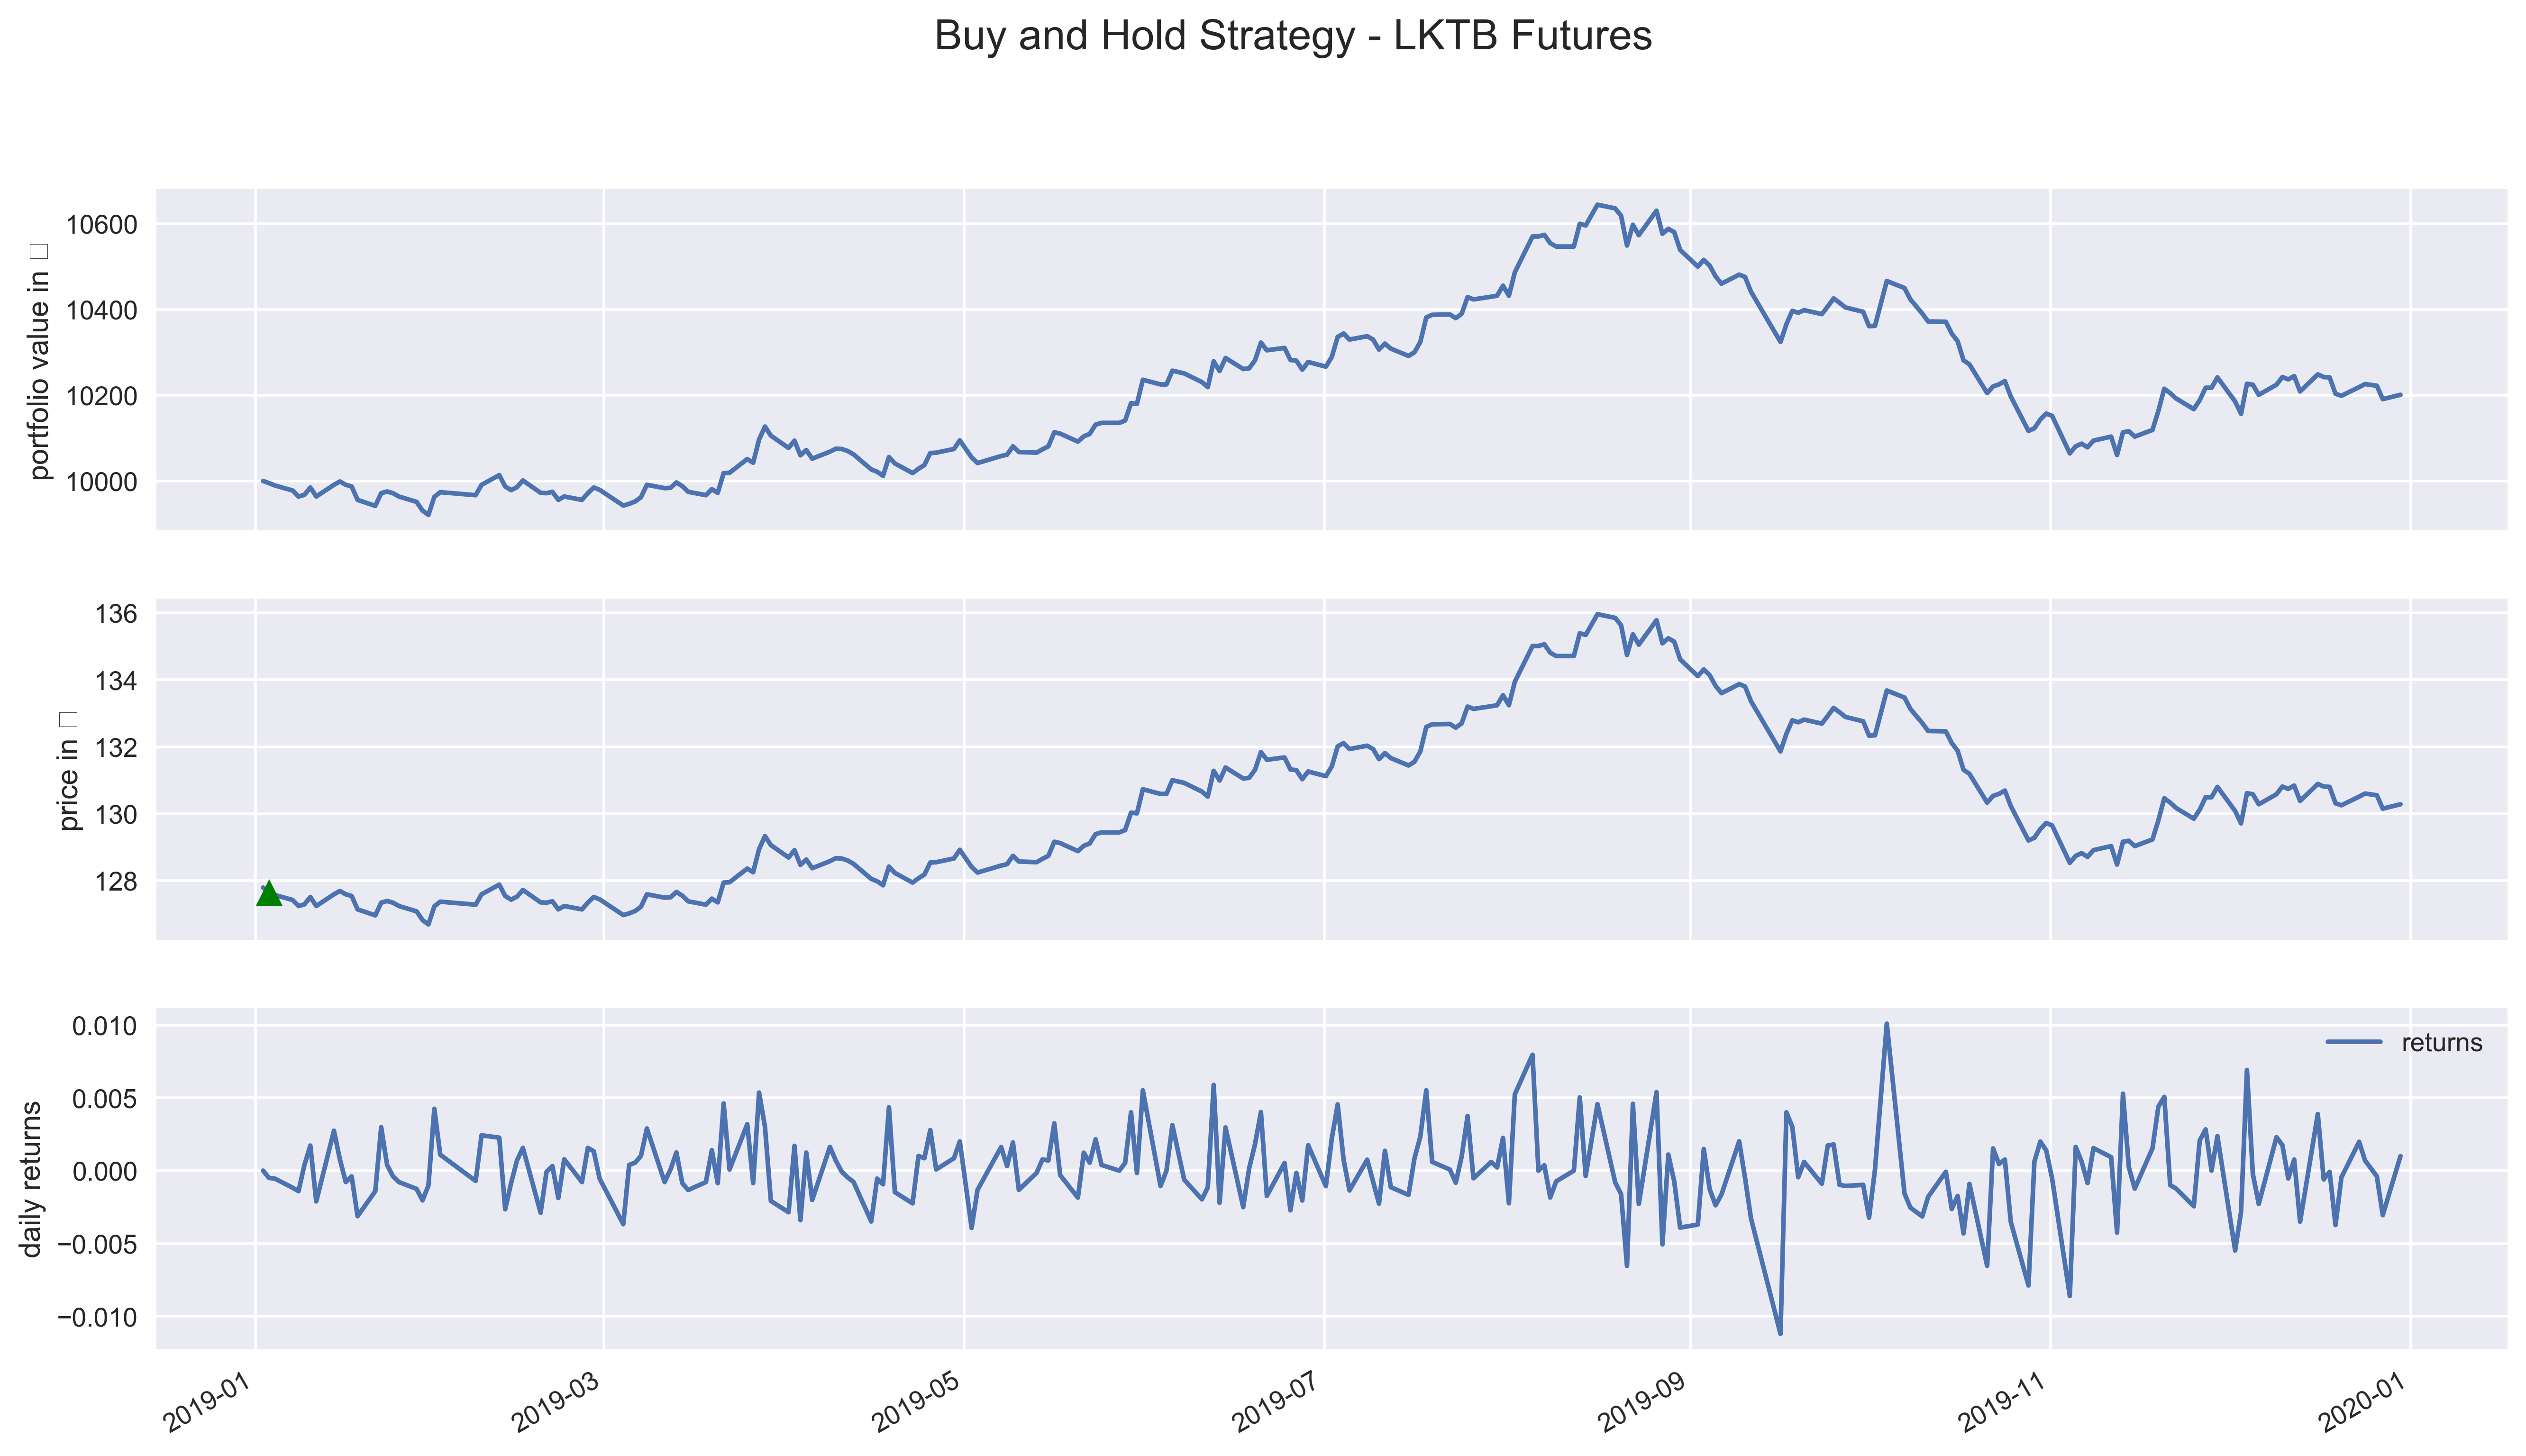

Final portfolio value (including cash): 10200.94￦


In [11]:
# import helper functions 
import qf_helper_functions as qf

qf.visualize_results(buy_and_hold_results, 'Buy and Hold Strategy - LKTB Futures', '￦')

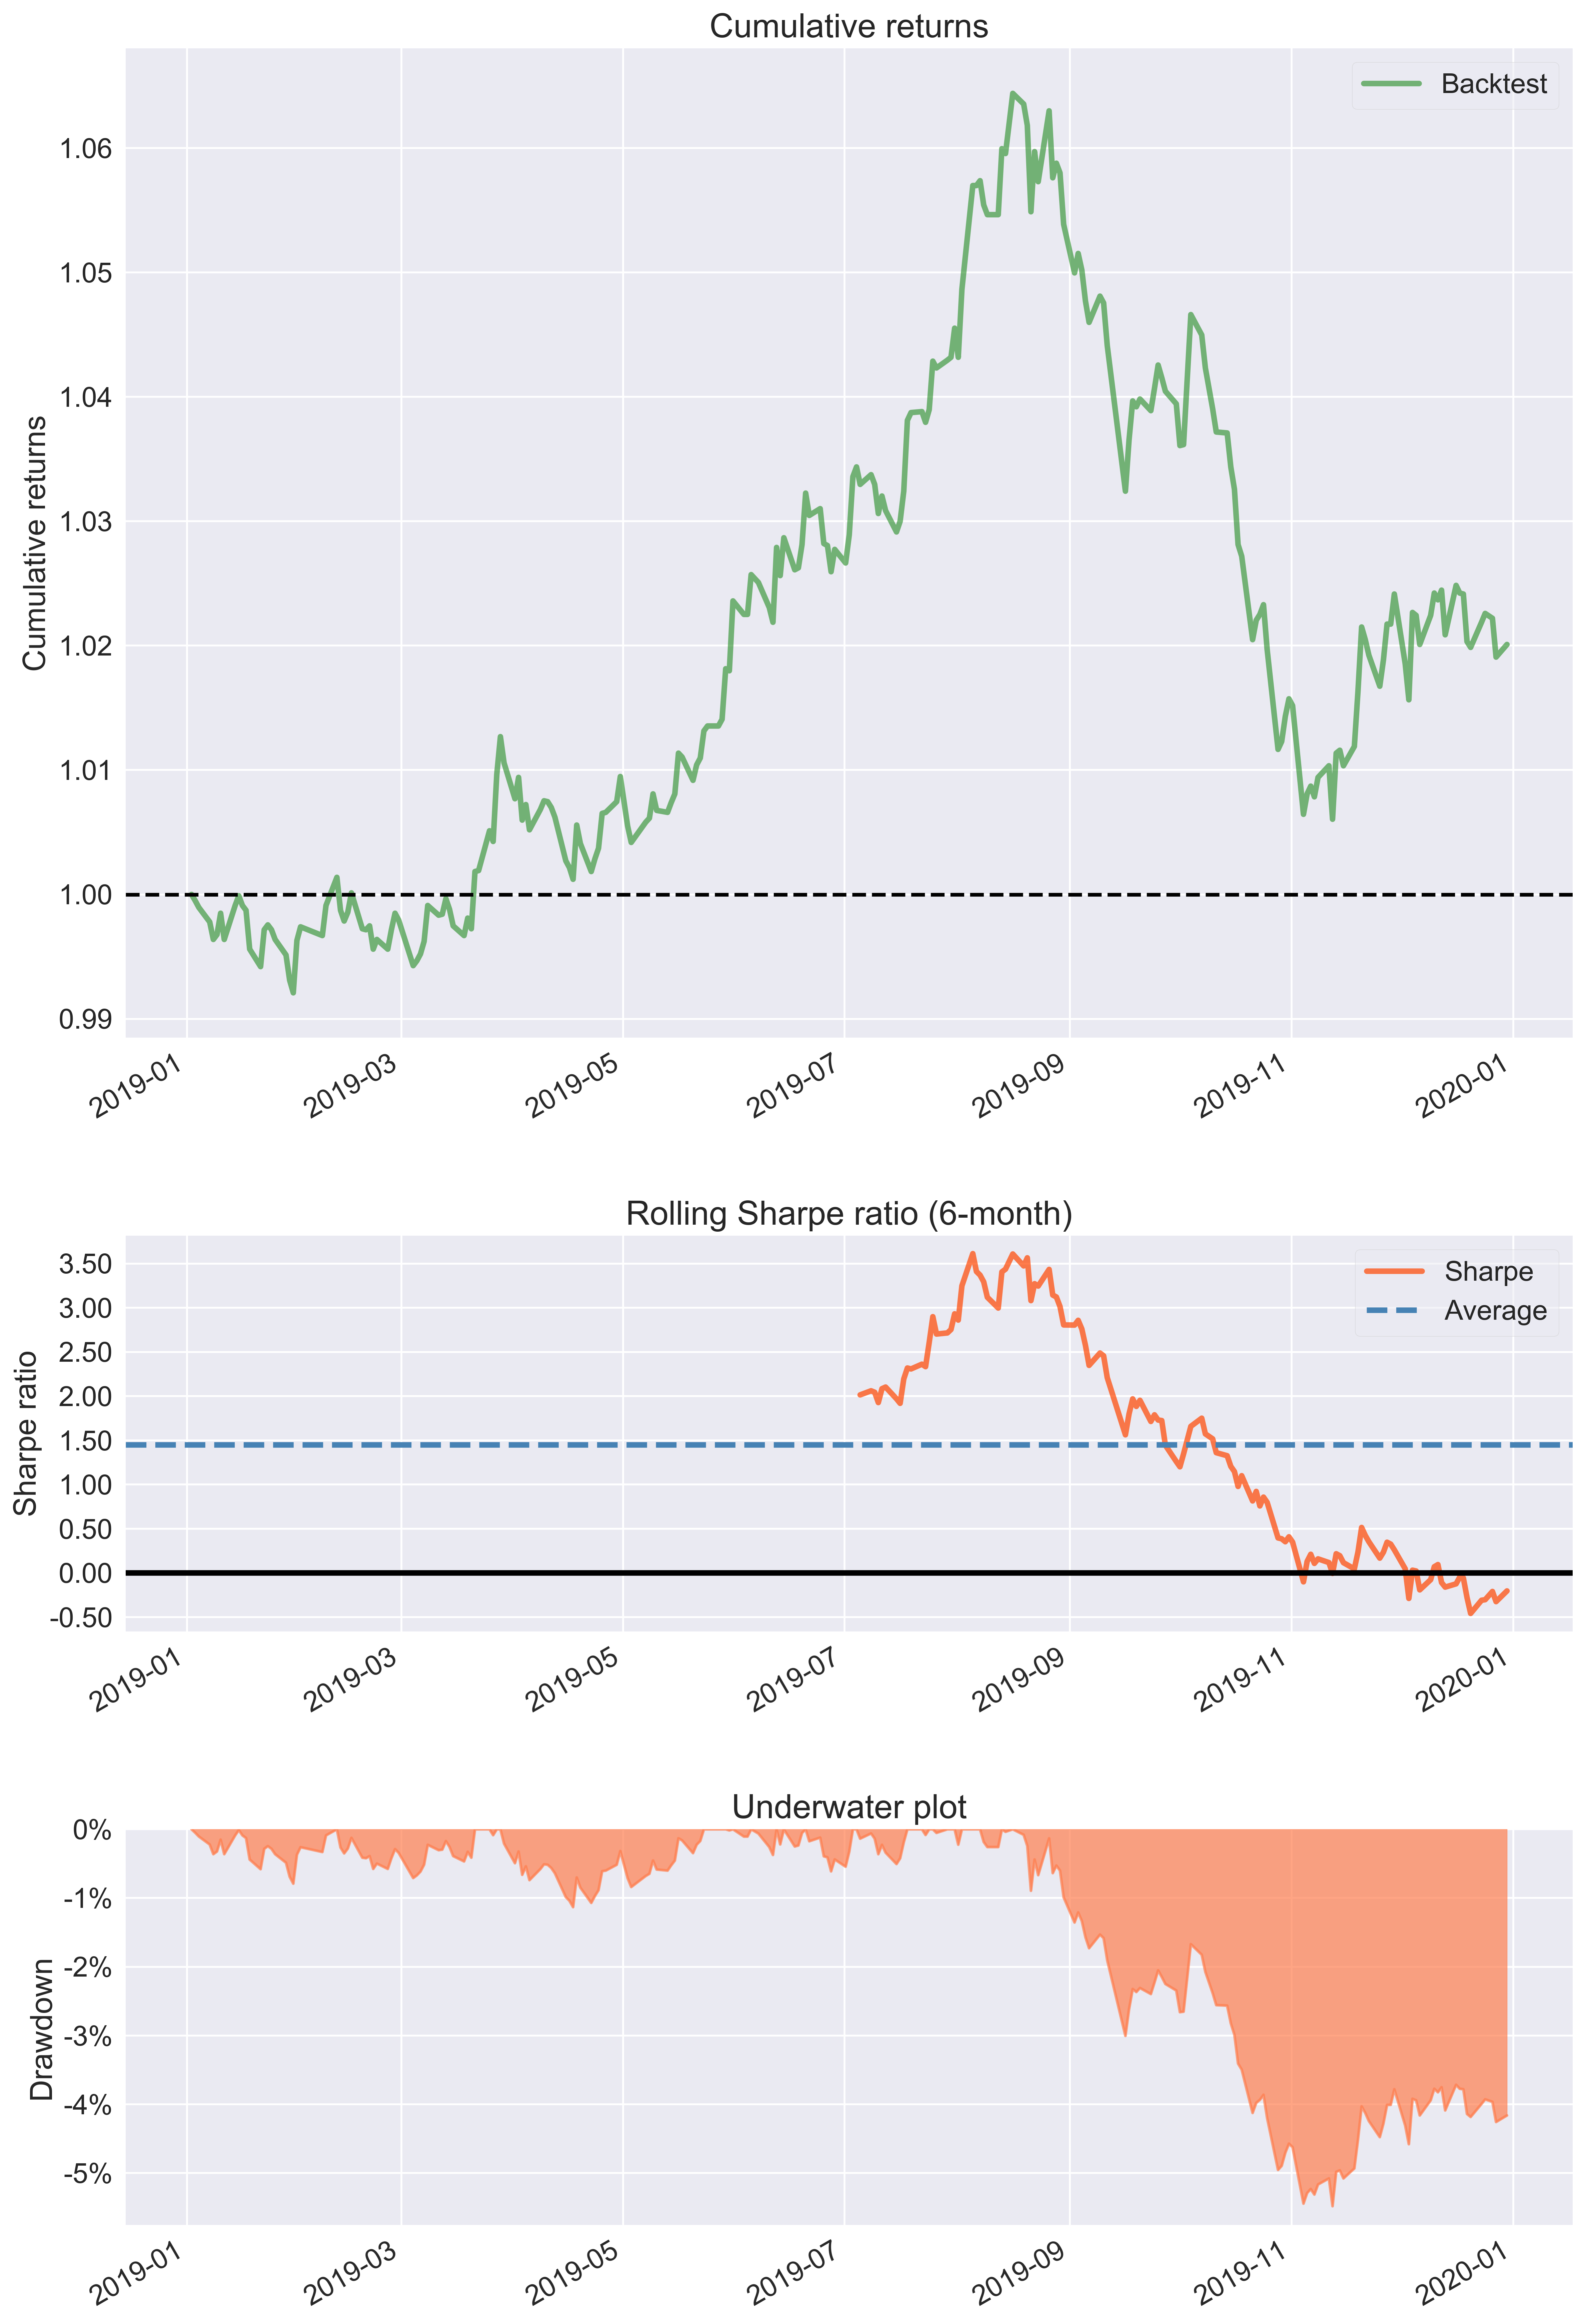

In [12]:
import pyfolio as pf

# possible additional summary statistics
pf.create_simple_tear_sheet(buy_and_hold_results.returns)

In [13]:
buy_and_hold_perf = qf.get_performance_summary(buy_and_hold_results.returns)

### Simple Moving Average Strategy

In [14]:
%%zipline --start 2019-1-2 --end 2019-12-30 --capital-base 10000 --bundle krx_futures -o simple_moving_average.pkl --trading-calendar XKRX

# imports 
from zipline.api import order_percent, record, symbol, order_target
from zipline.finance import commission

# parameters 
MA_PERIODS = 20
SELECTED_STOCK = 'LKTB'

def initialize(context):
    context.asset = symbol(SELECTED_STOCK)
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.has_position = False

def handle_data(context, data):
    
    price_history = data.history(context.asset, fields="price", bar_count=MA_PERIODS, frequency="1d")
    ma = price_history.mean()
    
    # cross up
    if (price_history[-2] < ma) & (price_history[-1] > ma) & (not context.has_position):
        order_percent(context.asset, 1.0)
        context.has_position = True
    # cross down
    elif (price_history[-2] > ma) & (price_history[-1] < ma) & (context.has_position):
        order_target(context.asset, 0)
        context.has_position = False

    record(price=data.current(context.asset, 'price'),
           moving_average=ma)

C:\ProgramData\Anaconda3\envs\backtest\lib\site-packages\empyrical\stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
C:\ProgramData\Anaconda3\envs\backtest\lib\site-packages\empyrical\stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


algo_volatility  algorithm_period_return alpha  \
2019-01-02 06:30:00+00:00              NaN                 0.000000  None   
2019-01-03 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-04 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-07 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-08 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-09 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-10 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-11 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-14 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-15 06:30:00+00:00         0.002500                -0.000498  None   
2019-01-16 06:30:00+00:00         0.004225                -0.001278  None   
2019-01-17 06:30:00+00:00         0.005362                -0.002165  None   
2019-01-18 06:30:00+00:00         0.005195                -0.002165  None   
2019-01-21 06:30:00+00:00         0.005041                -0.002165  None   
2019-01-22 06:30:00+00:00         0.004899                -0.002165  None   
2019-01-23 06:30:00+00:00         0.004768                -0.002165  None   
2019-01-24 06:30:00+00:00         0.004646                -0.002165  None   
2019-01-25 06:30:00+00:00         0.004532                -0.002165  None   
2019-01-28 06:30:00+00:00         0.004426                -0.002165  None   
2019-01-29 06:30:00+00:00         0.004327                -0.002165  None   
2019-01-30 06:30:00+00:00         0.004234                -0.002165  None   
2019-01-31 06:30:00+00:00         0.004147                -0.002165  None   
2019-02-01 06:30:00+00:00         0.004065                -0.002165  None   
2019-02-07 06:30:00+00:00         0.004185                -0.002662  None   
2019-02-08 06:30:00+00:00         0.009032                -0.000244  None   
2019-02-11 06:30:00+00:00         0.011329                 0.002018  None   
2019-02-12 06:30:00+00:00         0.013882                -0.000634  None   
2019-02-13 06:30:00+00:00         0.013851                -0.001492  None   
2019-02-14 06:30:00+00:00         0.013782                -0.000790  None   
2019-02-15 06:30:00+00:00         0.014304                 0.000770  None   
...                                    ...                      ...   ...   
2019-11-18 06:30:00+00:00         0.029580                 0.011526  None   
2019-11-19 06:30:00+00:00         0.029511                 0.011526  None   
2019-11-20 06:30:00+00:00         0.029450                 0.011024  None   
2019-11-21 06:30:00+00:00         0.029403                 0.010023  None   
2019-11-22 06:30:00+00:00         0.029368                 0.008783  None   
2019-11-25 06:30:00+00:00         0.029420                 0.006327  None   
2019-11-26 06:30:00+00:00         0.029433                 0.008406  None   
2019-11-27 06:30:00+00:00         0.029516                 0.011255  None   
2019-11-28 06:30:00+00:00         0.029450                 0.011255  None   
2019-11-29 06:30:00+00:00         0.029485                 0.013642  None   
2019-12-02 06:30:00+00:00         0.029991                 0.008098  None   
2019-12-03 06:30:00+00:00         0.030076                 0.005249  None   
2019-12-04 06:30:00+00:00         0.030863                 0.012179  None   
2019-12-05 06:30:00+00:00         0.030797                 0.011948  None   
2019-12-06 06:30:00+00:00         0.030827                 0.009638  None   
2019-12-09 06:30:00+00:00         0.030849                 0.011948  None   
2019-12-10 06:30:00+00:00         0.030833                 0.013719  None   
2019-12-11 06:30:00+00:00         0.030773                 0.013180  None   
2019-12-12 06:30:00+00:00         0.030716                 0.013950  None   
2019-12-13 06:30:00+00:00         0.030870                 0.010408  None   
2019-12-16 06:30:00+00:

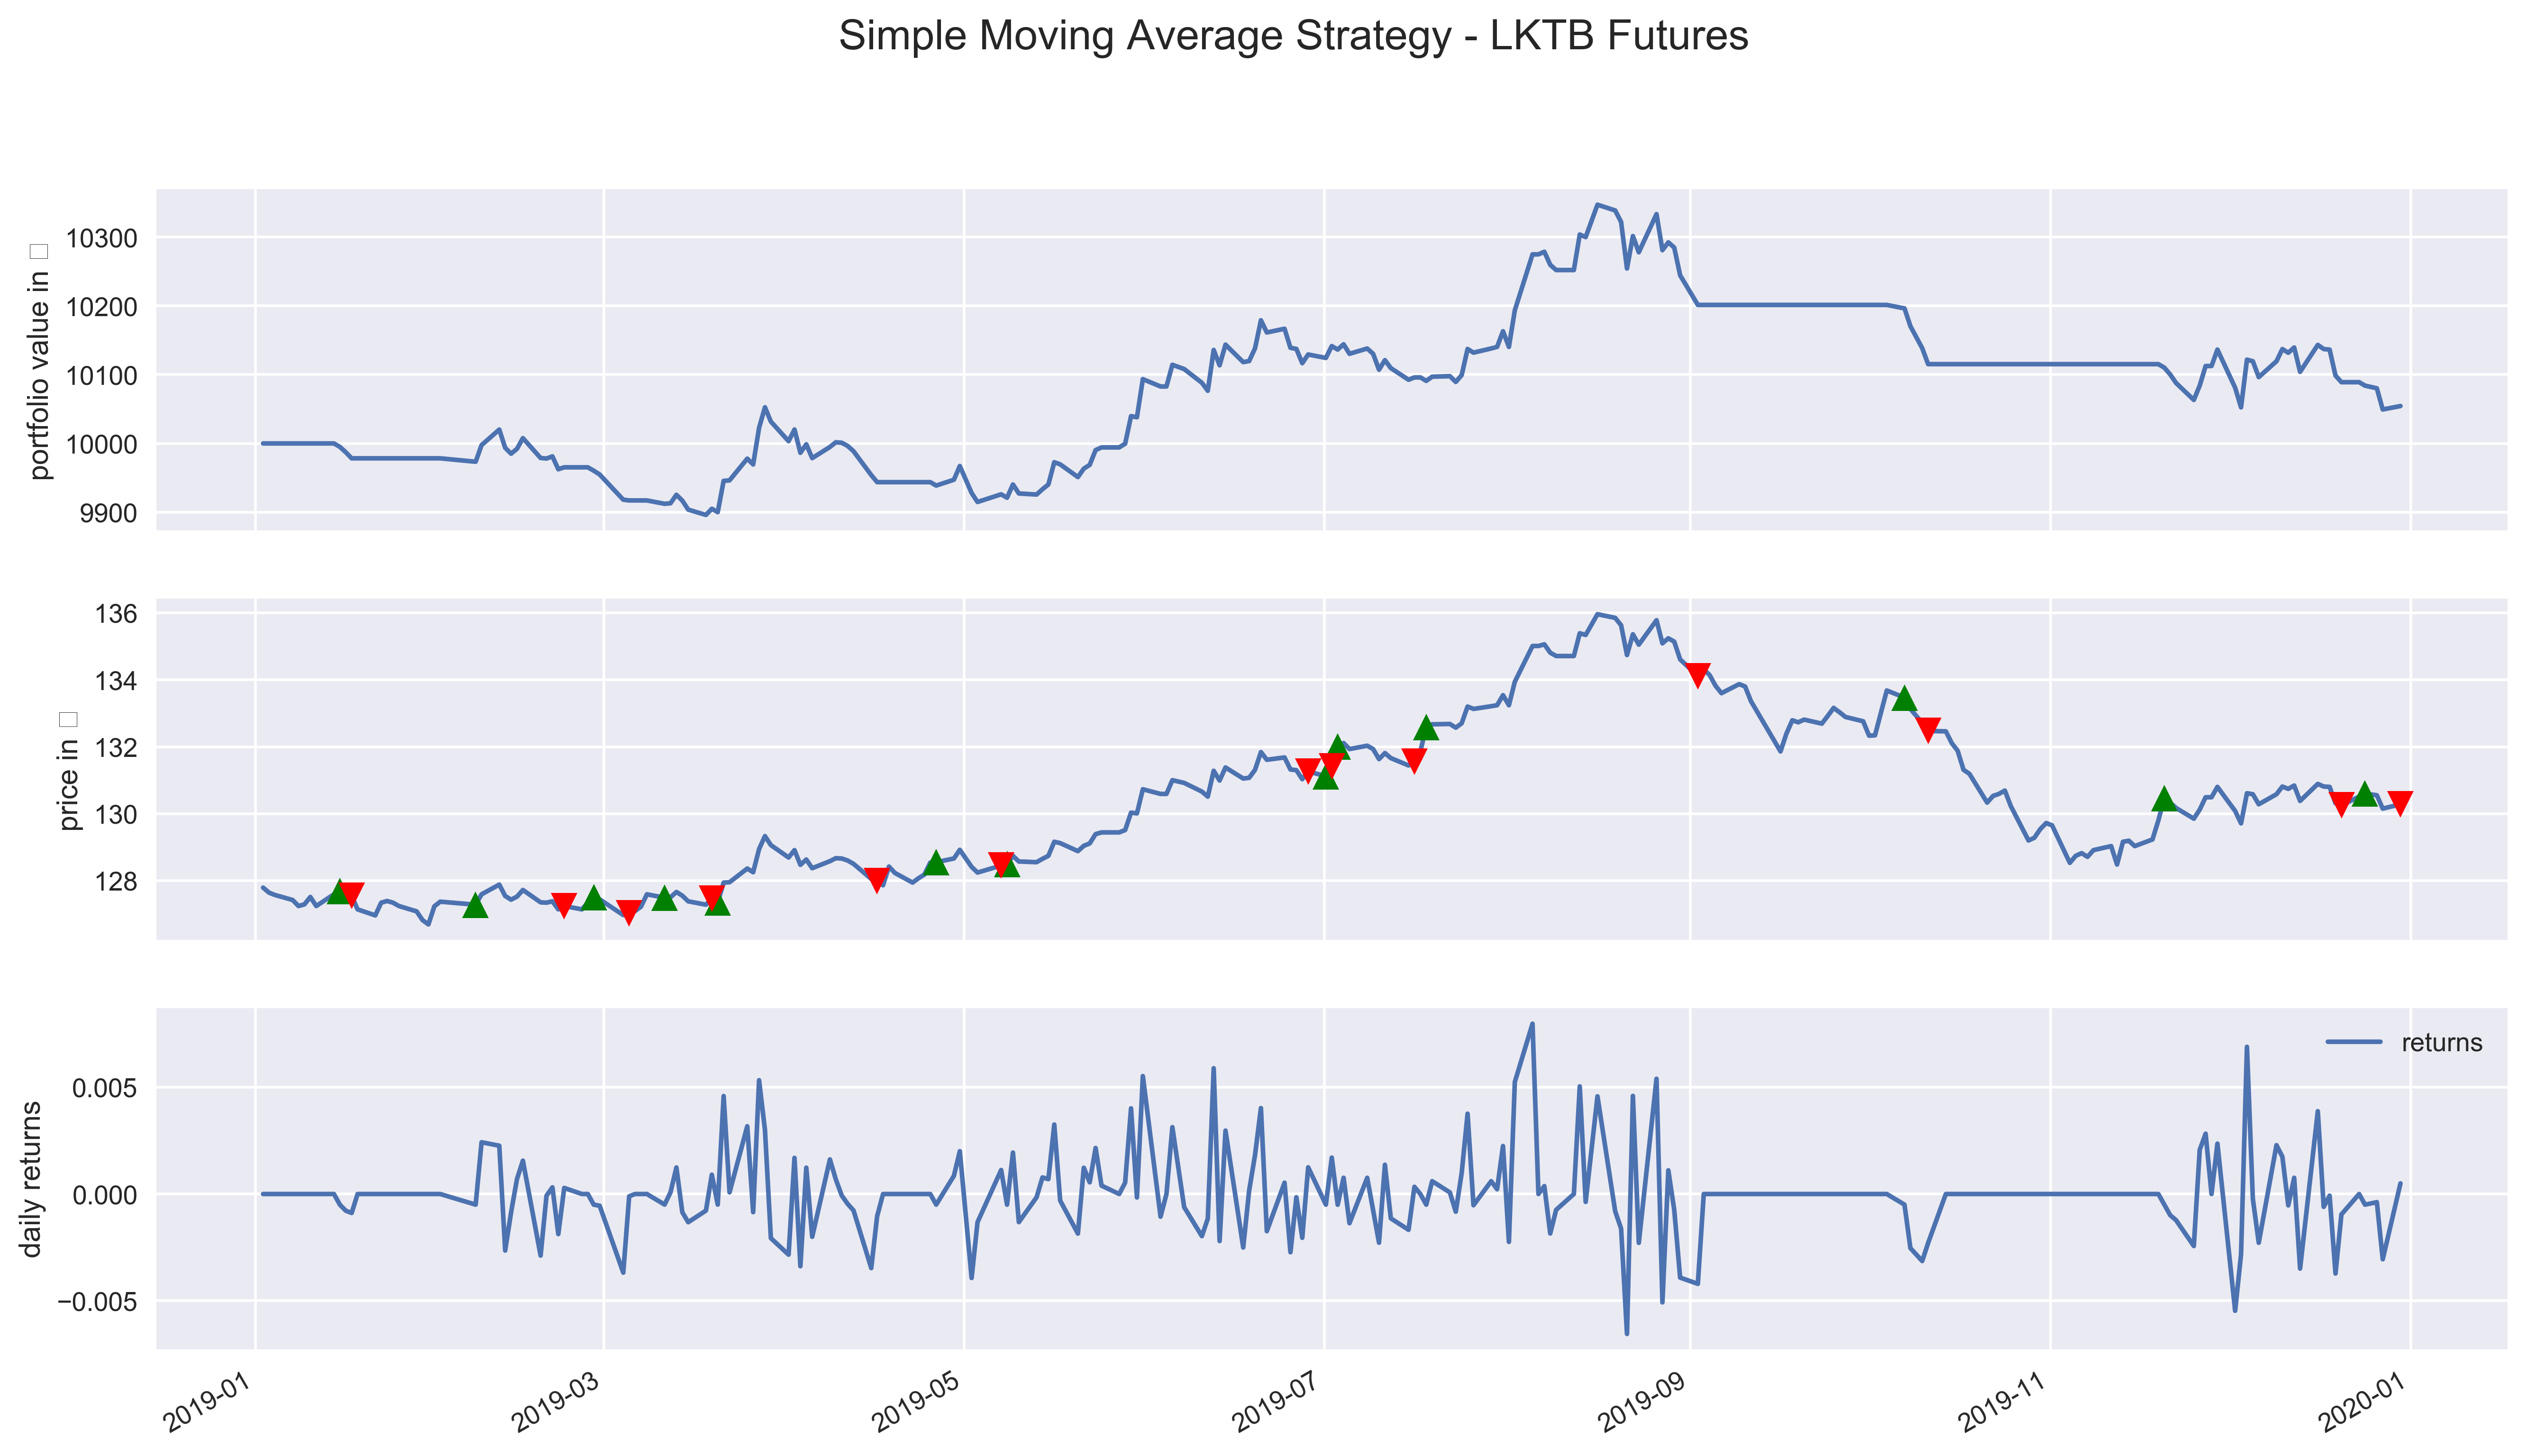

Final portfolio value (including cash): 10054.37￦


In [15]:
sma_results = pd.read_pickle('simple_moving_average.pkl')
qf.visualize_results(sma_results, 'Simple Moving Average Strategy - LKTB Futures', '￦')

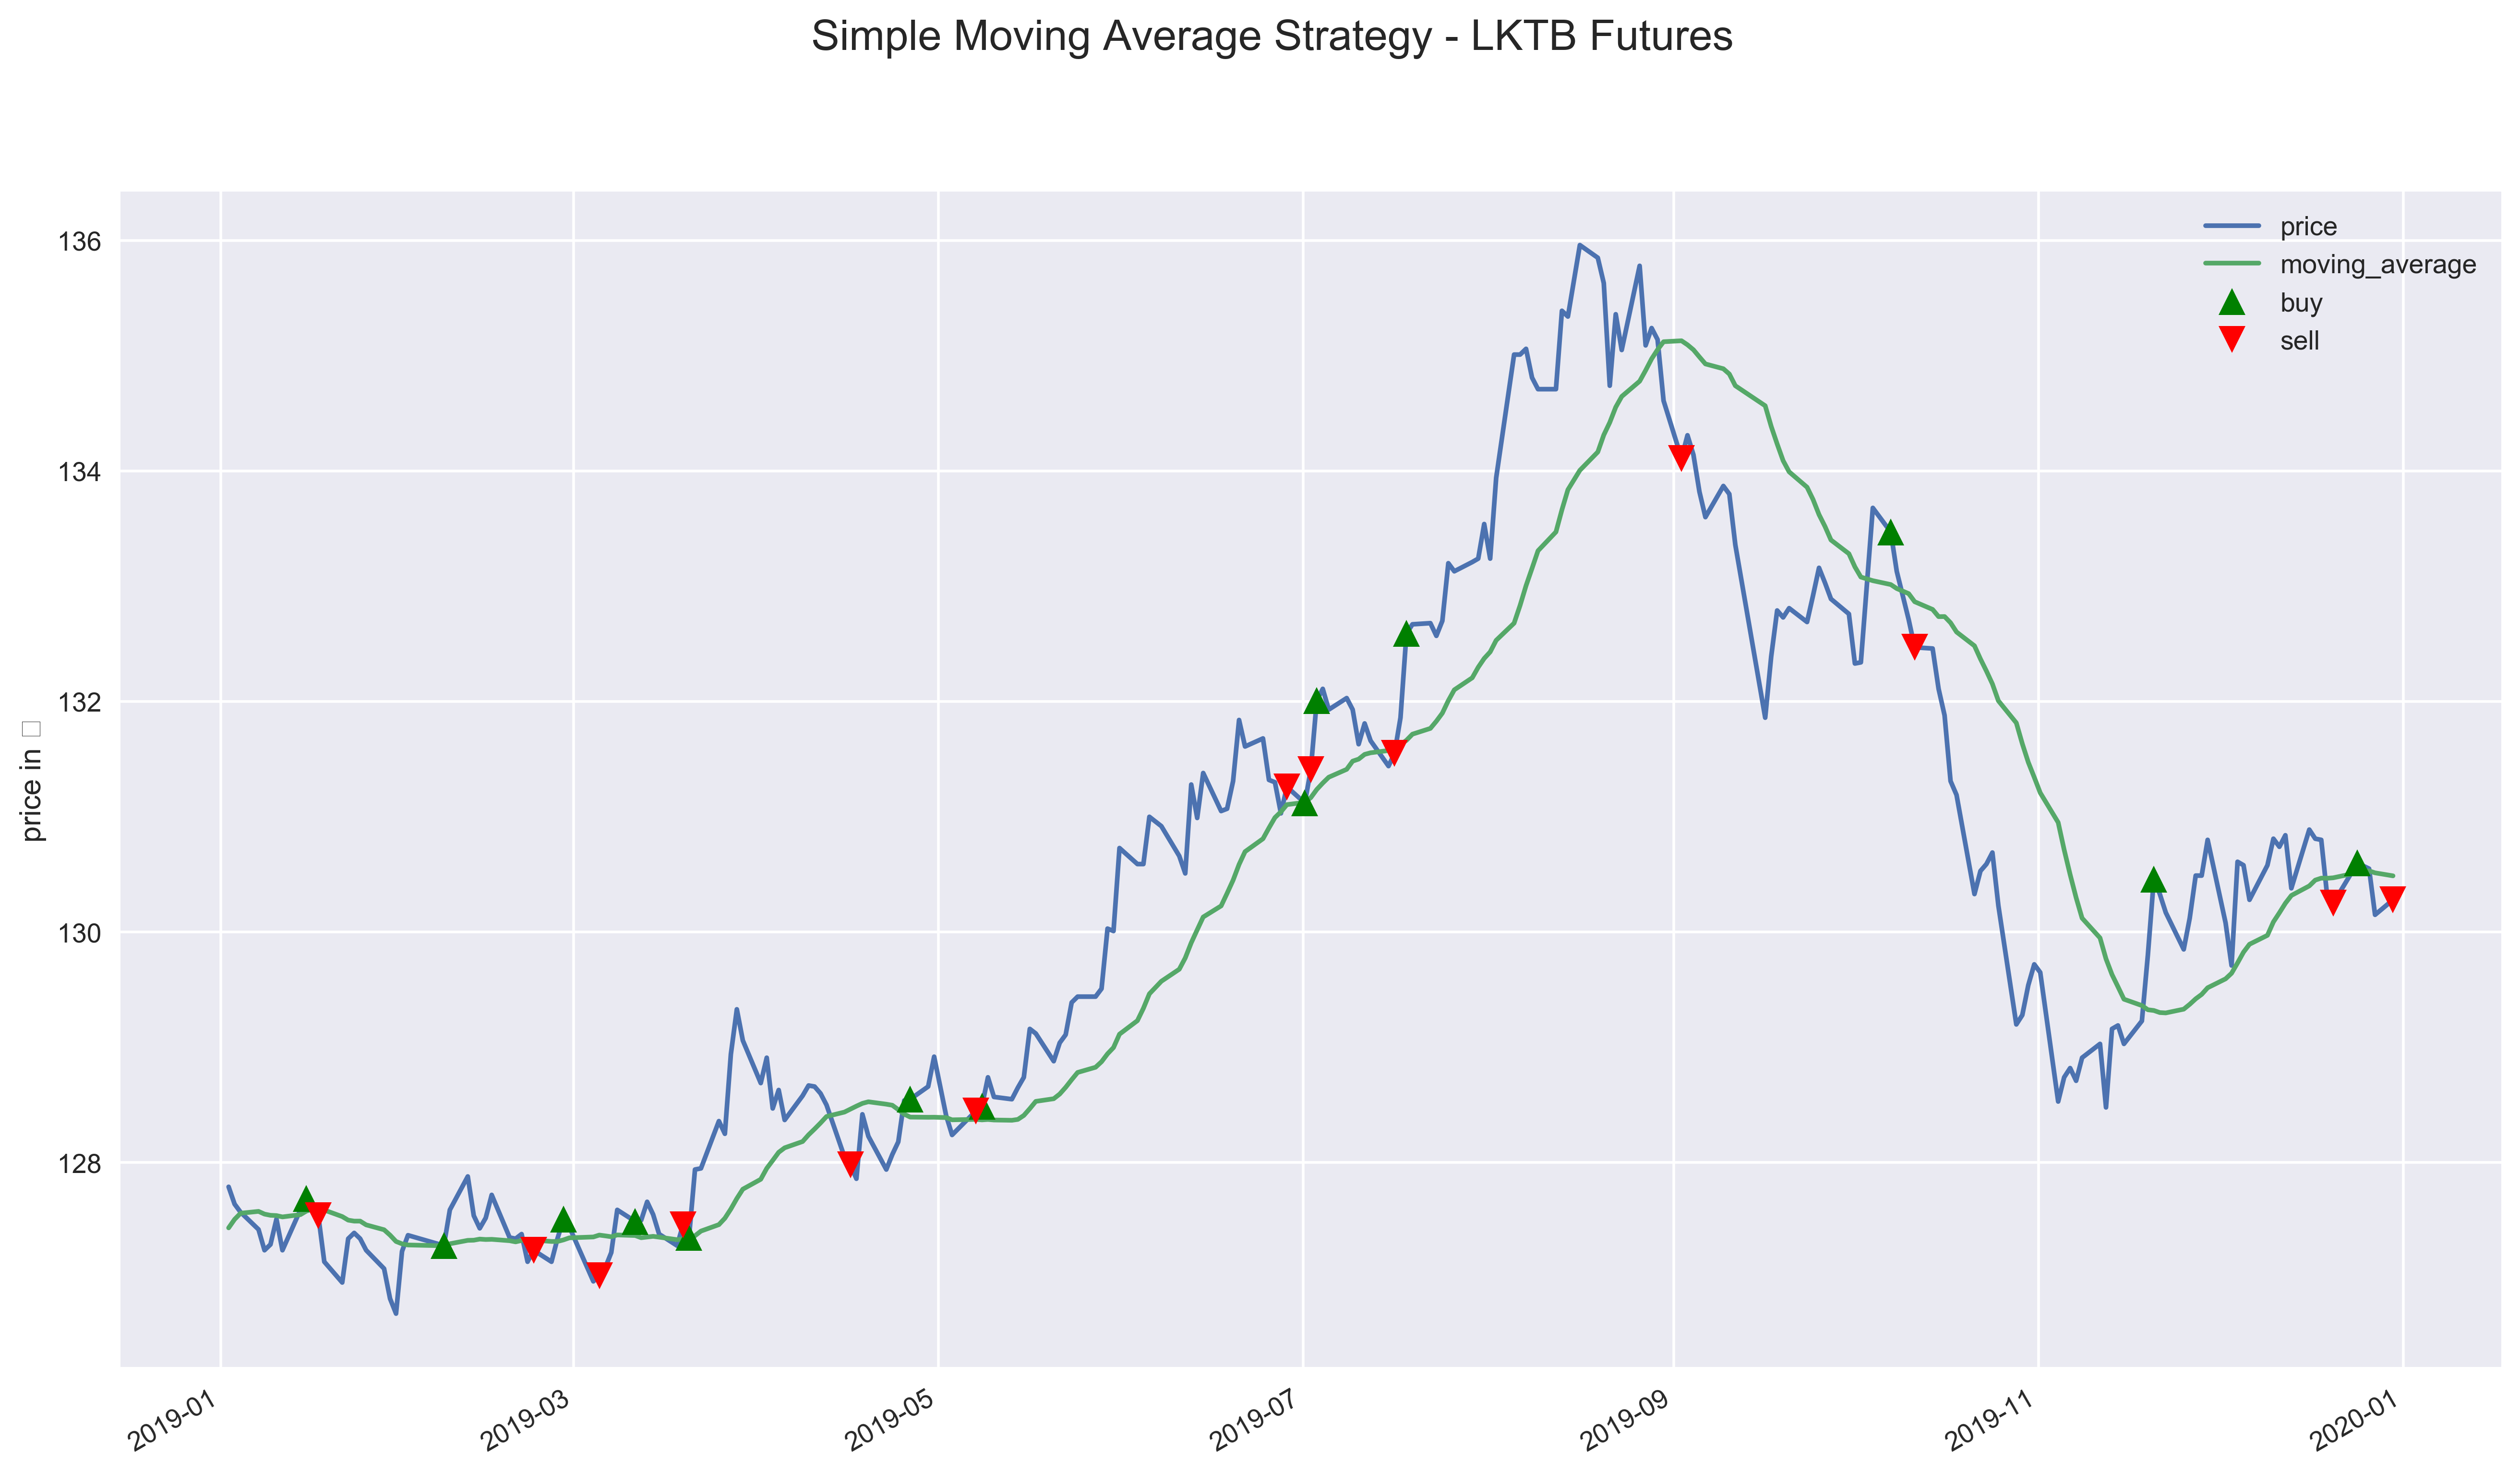

In [16]:
fig, ax = plt.subplots()

# asset
sma_results[['price', 'moving_average']].plot(ax=ax)
ax.set_ylabel('price in ￦')

# mark transactions
perf_trans = sma_results.loc[[t != [] for t in sma_results.transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
ax.plot(buys.index, sma_results.price.loc[buys.index], '^', markersize=10, color='g', label='buy')
ax.plot(sells.index, sma_results.price.loc[sells.index], 'v', markersize=10, color='r', label='sell')
ax.legend()

fig.suptitle('Simple Moving Average Strategy - LKTB Futures', fontsize=16)
plt.legend()
plt.show()

In [17]:
sma_perf = qf.get_performance_summary(sma_results.returns)

In [18]:
%%zipline --start 2019-1-2 --end 2019-12-30 --capital-base 10000 --bundle krx_futures -o moving_average_crossover.pkl --trading-calendar XKRX

# imports 
from zipline.api import order_percent, record, symbol, order_target
from zipline.finance import commission

# parameters 
SELECTED_STOCK = 'LKTB'
SLOW_MA_PERIODS = 100
FAST_MA_PERIODS = 20

def initialize(context):
    context.asset = symbol(SELECTED_STOCK)
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.has_position = False
    
def handle_data(context, data):

    fast_ma = data.history(context.asset, 'price', bar_count=FAST_MA_PERIODS, frequency="1d").mean()
    slow_ma = data.history(context.asset, 'price', bar_count=SLOW_MA_PERIODS, frequency="1d").mean()

    # Trading logic
    if (fast_ma > slow_ma) & (not context.has_position):
        order_percent(context.asset, 1.0)
        context.has_position = True
    elif (fast_ma < slow_ma) & (context.has_position):
        order_target(context.asset, 0)
        context.has_position = False

    record(price=data.current(context.asset, 'price'),
           fast_ma=fast_ma,
           slow_ma=slow_ma)

algo_volatility  algorithm_period_return alpha  \
2019-01-02 06:30:00+00:00              NaN                 0.000000  None   
2019-01-03 06:30:00+00:00         0.005588                -0.000498  None   
2019-01-04 06:30:00+00:00         0.004800                -0.001044  None   
2019-01-07 06:30:00+00:00         0.007619                -0.002214  None   
2019-01-08 06:30:00+00:00         0.008957                -0.003618  None   
2019-01-09 06:30:00+00:00         0.010793                -0.003228  None   
2019-01-10 06:30:00+00:00         0.016762                -0.001512  None   
2019-01-11 06:30:00+00:00         0.018809                -0.003618  None   
2019-01-14 06:30:00+00:00         0.024390                -0.000888  None   
2019-01-15 06:30:00+00:00         0.023414                -0.000108  None   
2019-01-16 06:30:00+00:00         0.022516                -0.000888  None   
2019-01-17 06:30:00+00:00         0.021516                -0.001278  None   
2019-01-18 06:30:00+00:00         0.024514                -0.004398  None   
2019-01-21 06:30:00+00:00         0.023988                -0.005802  None   
2019-01-22 06:30:00+00:00         0.026982                -0.002838  None   
2019-01-23 06:30:00+00:00         0.026168                -0.002448  None   
2019-01-24 06:30:00+00:00         0.025354                -0.002838  None   
2019-01-25 06:30:00+00:00         0.024705                -0.003618  None   
2019-01-28 06:30:00+00:00         0.024313                -0.004866  None   
2019-01-29 06:30:00+00:00         0.024496                -0.006894  None   
2019-01-30 06:30:00+00:00         0.023990                -0.007908  None   
2019-01-31 06:30:00+00:00         0.028158                -0.003696  None   
2019-02-01 06:30:00+00:00         0.027826                -0.002604  None   
2019-02-07 06:30:00+00:00         0.027282                -0.003306  None   
2019-02-08 06:30:00+00:00         0.027919                -0.000888  None   
2019-02-11 06:30:00+00:00         0.028275                 0.001374  None   
2019-02-12 06:30:00+00:00         0.028930                -0.001278  None   
2019-02-13 06:30:00+00:00         0.028494                -0.002136  None   
2019-02-14 06:30:00+00:00         0.028074                -0.001434  None   
2019-02-15 06:30:00+00:00         0.027978                 0.000126  None   
...                                    ...                      ...   ...   
2019-11-18 06:30:00+00:00         0.039016                 0.019976  None   
2019-11-19 06:30:00+00:00         0.038926                 0.019976  None   
2019-11-20 06:30:00+00:00         0.038837                 0.019976  None   
2019-11-21 06:30:00+00:00         0.038748                 0.019976  None   
2019-11-22 06:30:00+00:00         0.038660                 0.019976  None   
2019-11-25 06:30:00+00:00         0.038573                 0.019976  None   
2019-11-26 06:30:00+00:00         0.038486                 0.019976  None   
2019-11-27 06:30:00+00:00         0.038400                 0.019976  None   
2019-11-28 06:30:00+00:00         0.038314                 0.019976  None   
2019-11-29 06:30:00+00:00         0.038229                 0.019976  None   
2019-12-02 06:30:00+00:00         0.038144                 0.019976  None   
2019-12-03 06:30:00+00:00         0.038060                 0.019976  None   
2019-12-04 06:30:00+00:00         0.037977                 0.019976  None   
2019-12-05 06:30:00+00:00         0.037894                 0.019976  None   
2019-12-06 06:30:00+00:00         0.037812                 0.019976  None   
2019-12-09 06:30:00+00:00         0.037730                 0.019976  None   
2019-12-10 06:30:00+00:00         0.037649                 0.019976  None   
2019-12-11 06:30:00+00:00         0.037568                 0.019976  None   
2019-12-12 06:30:00+00:00         0.037487                 0.019976  None   
2019-12-13 06:30:00+00:00         0.037408                 0.019976  None   
2019-12-16 06:30:00+00:

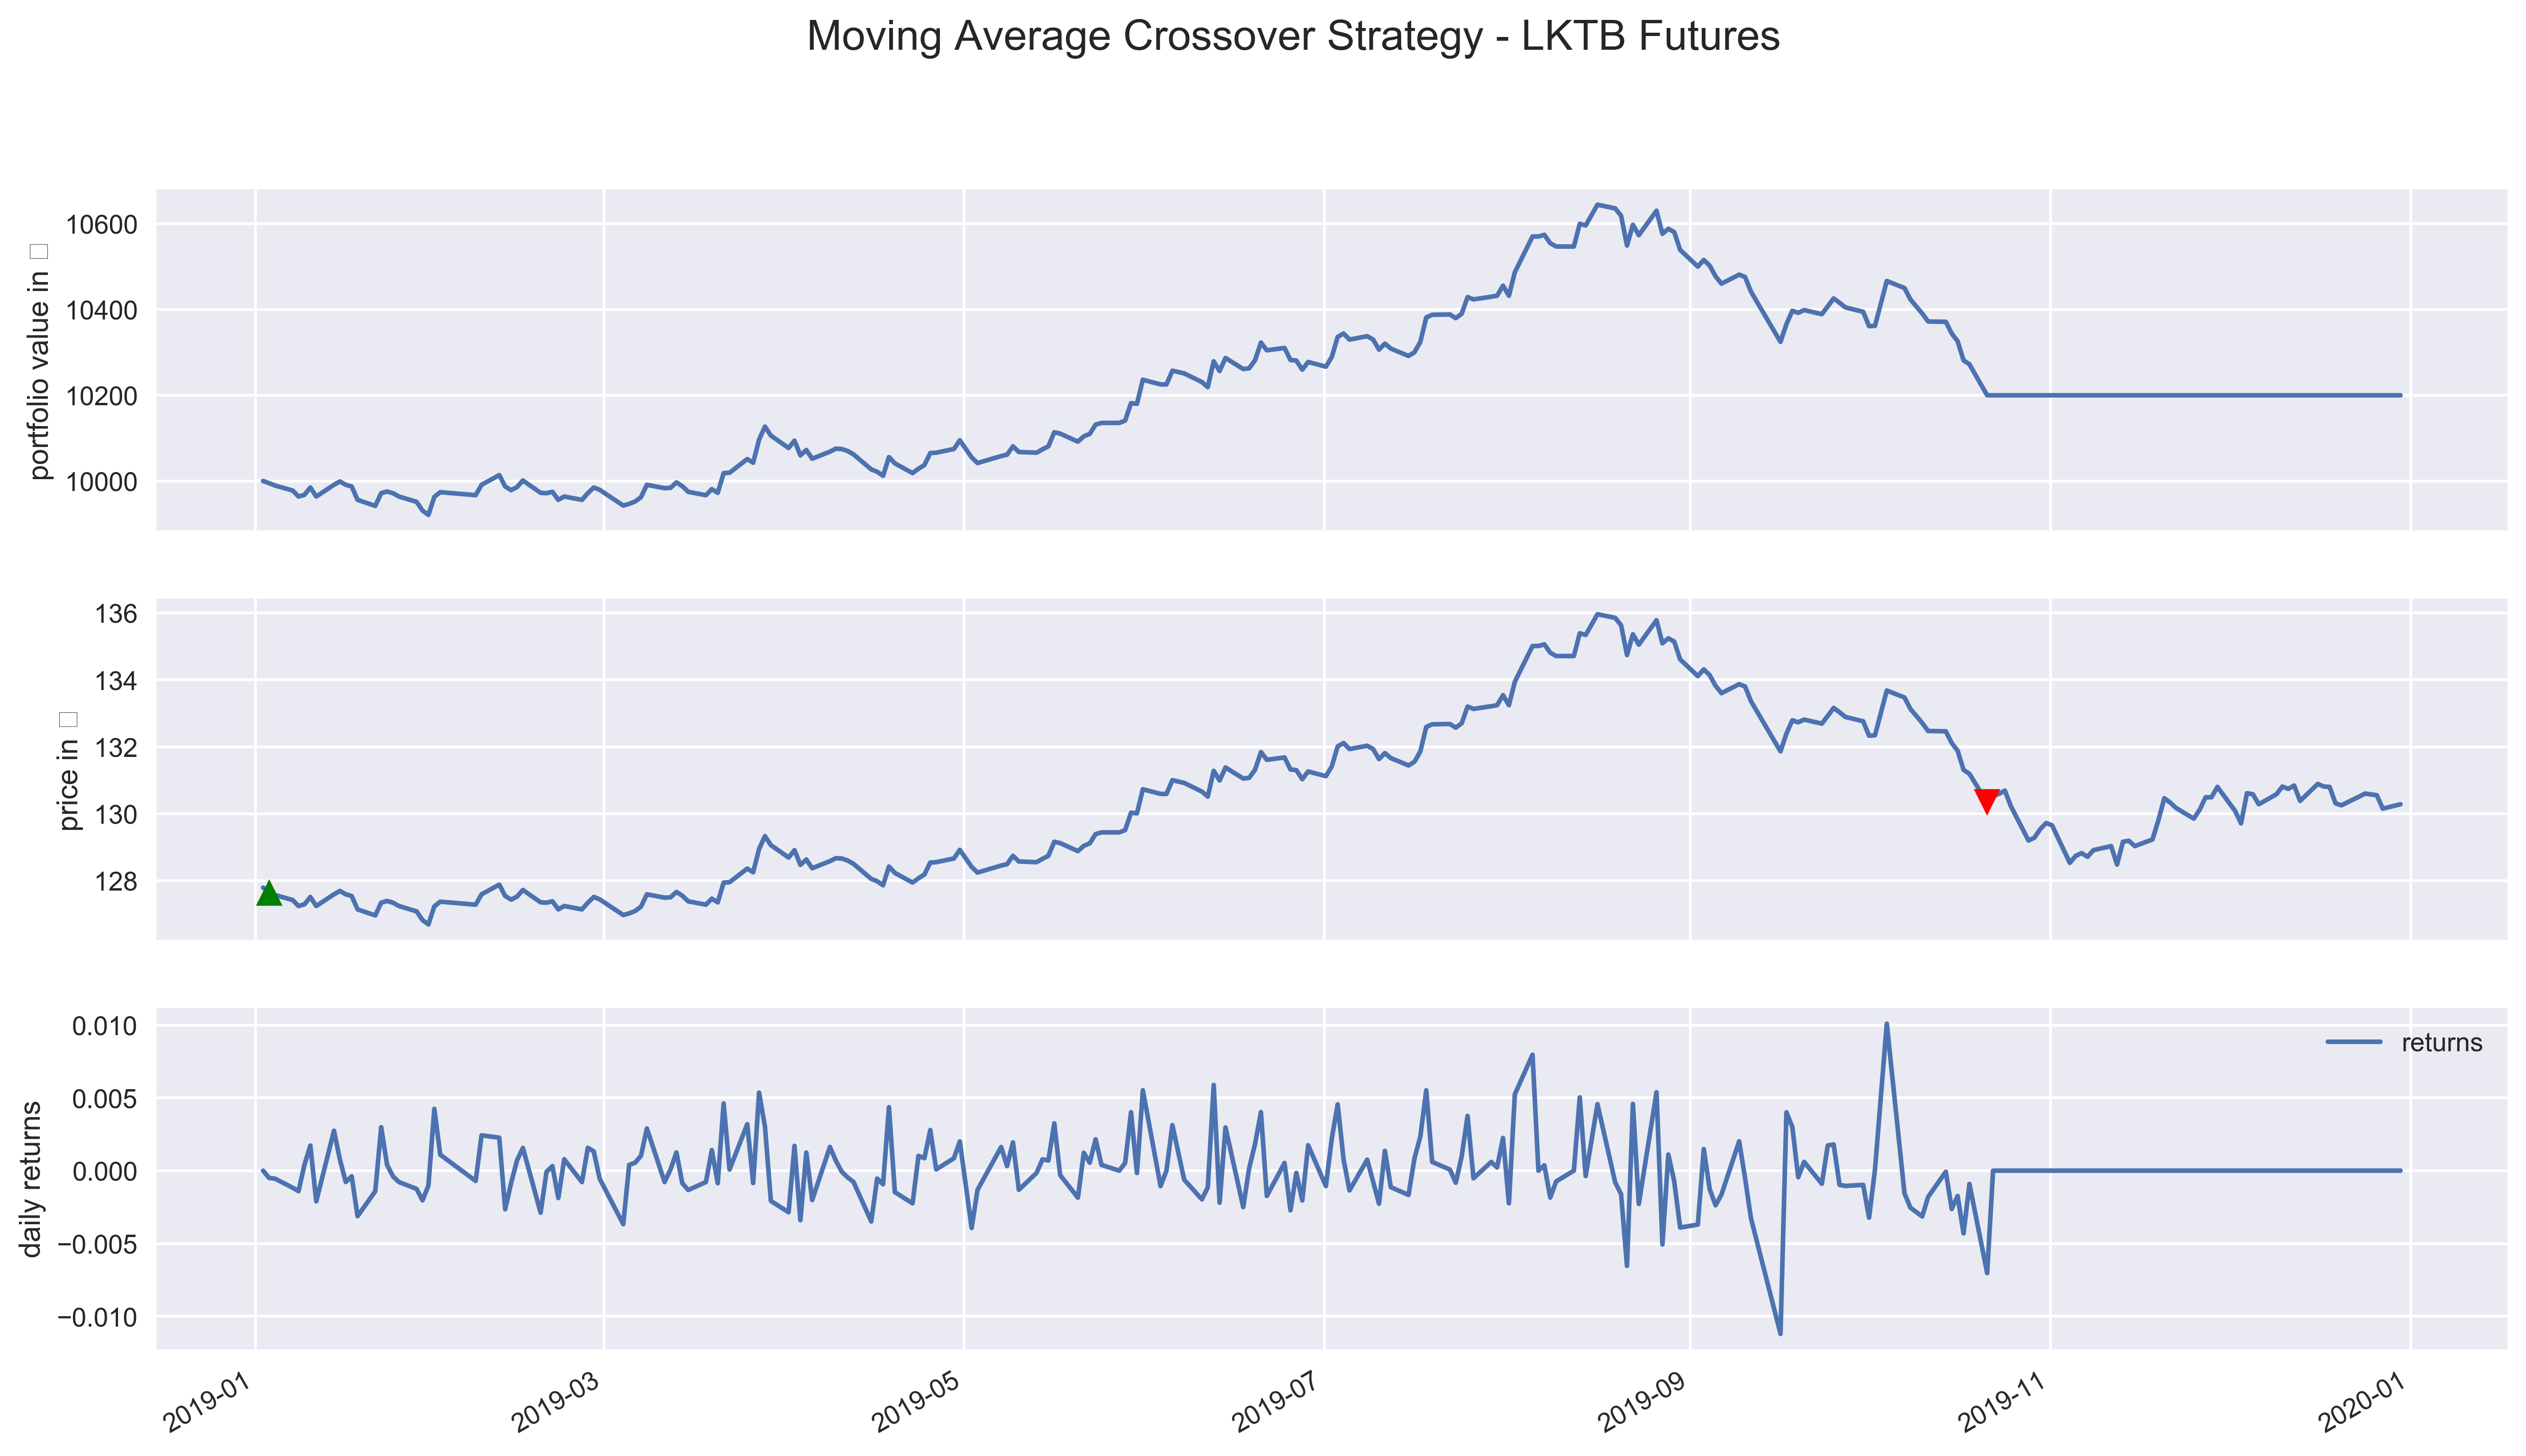

Final portfolio value (including cash): 10199.76￦


In [19]:
mac_results = pd.read_pickle('moving_average_crossover.pkl')
qf.visualize_results(mac_results, 'Moving Average Crossover Strategy - LKTB Futures', '￦')

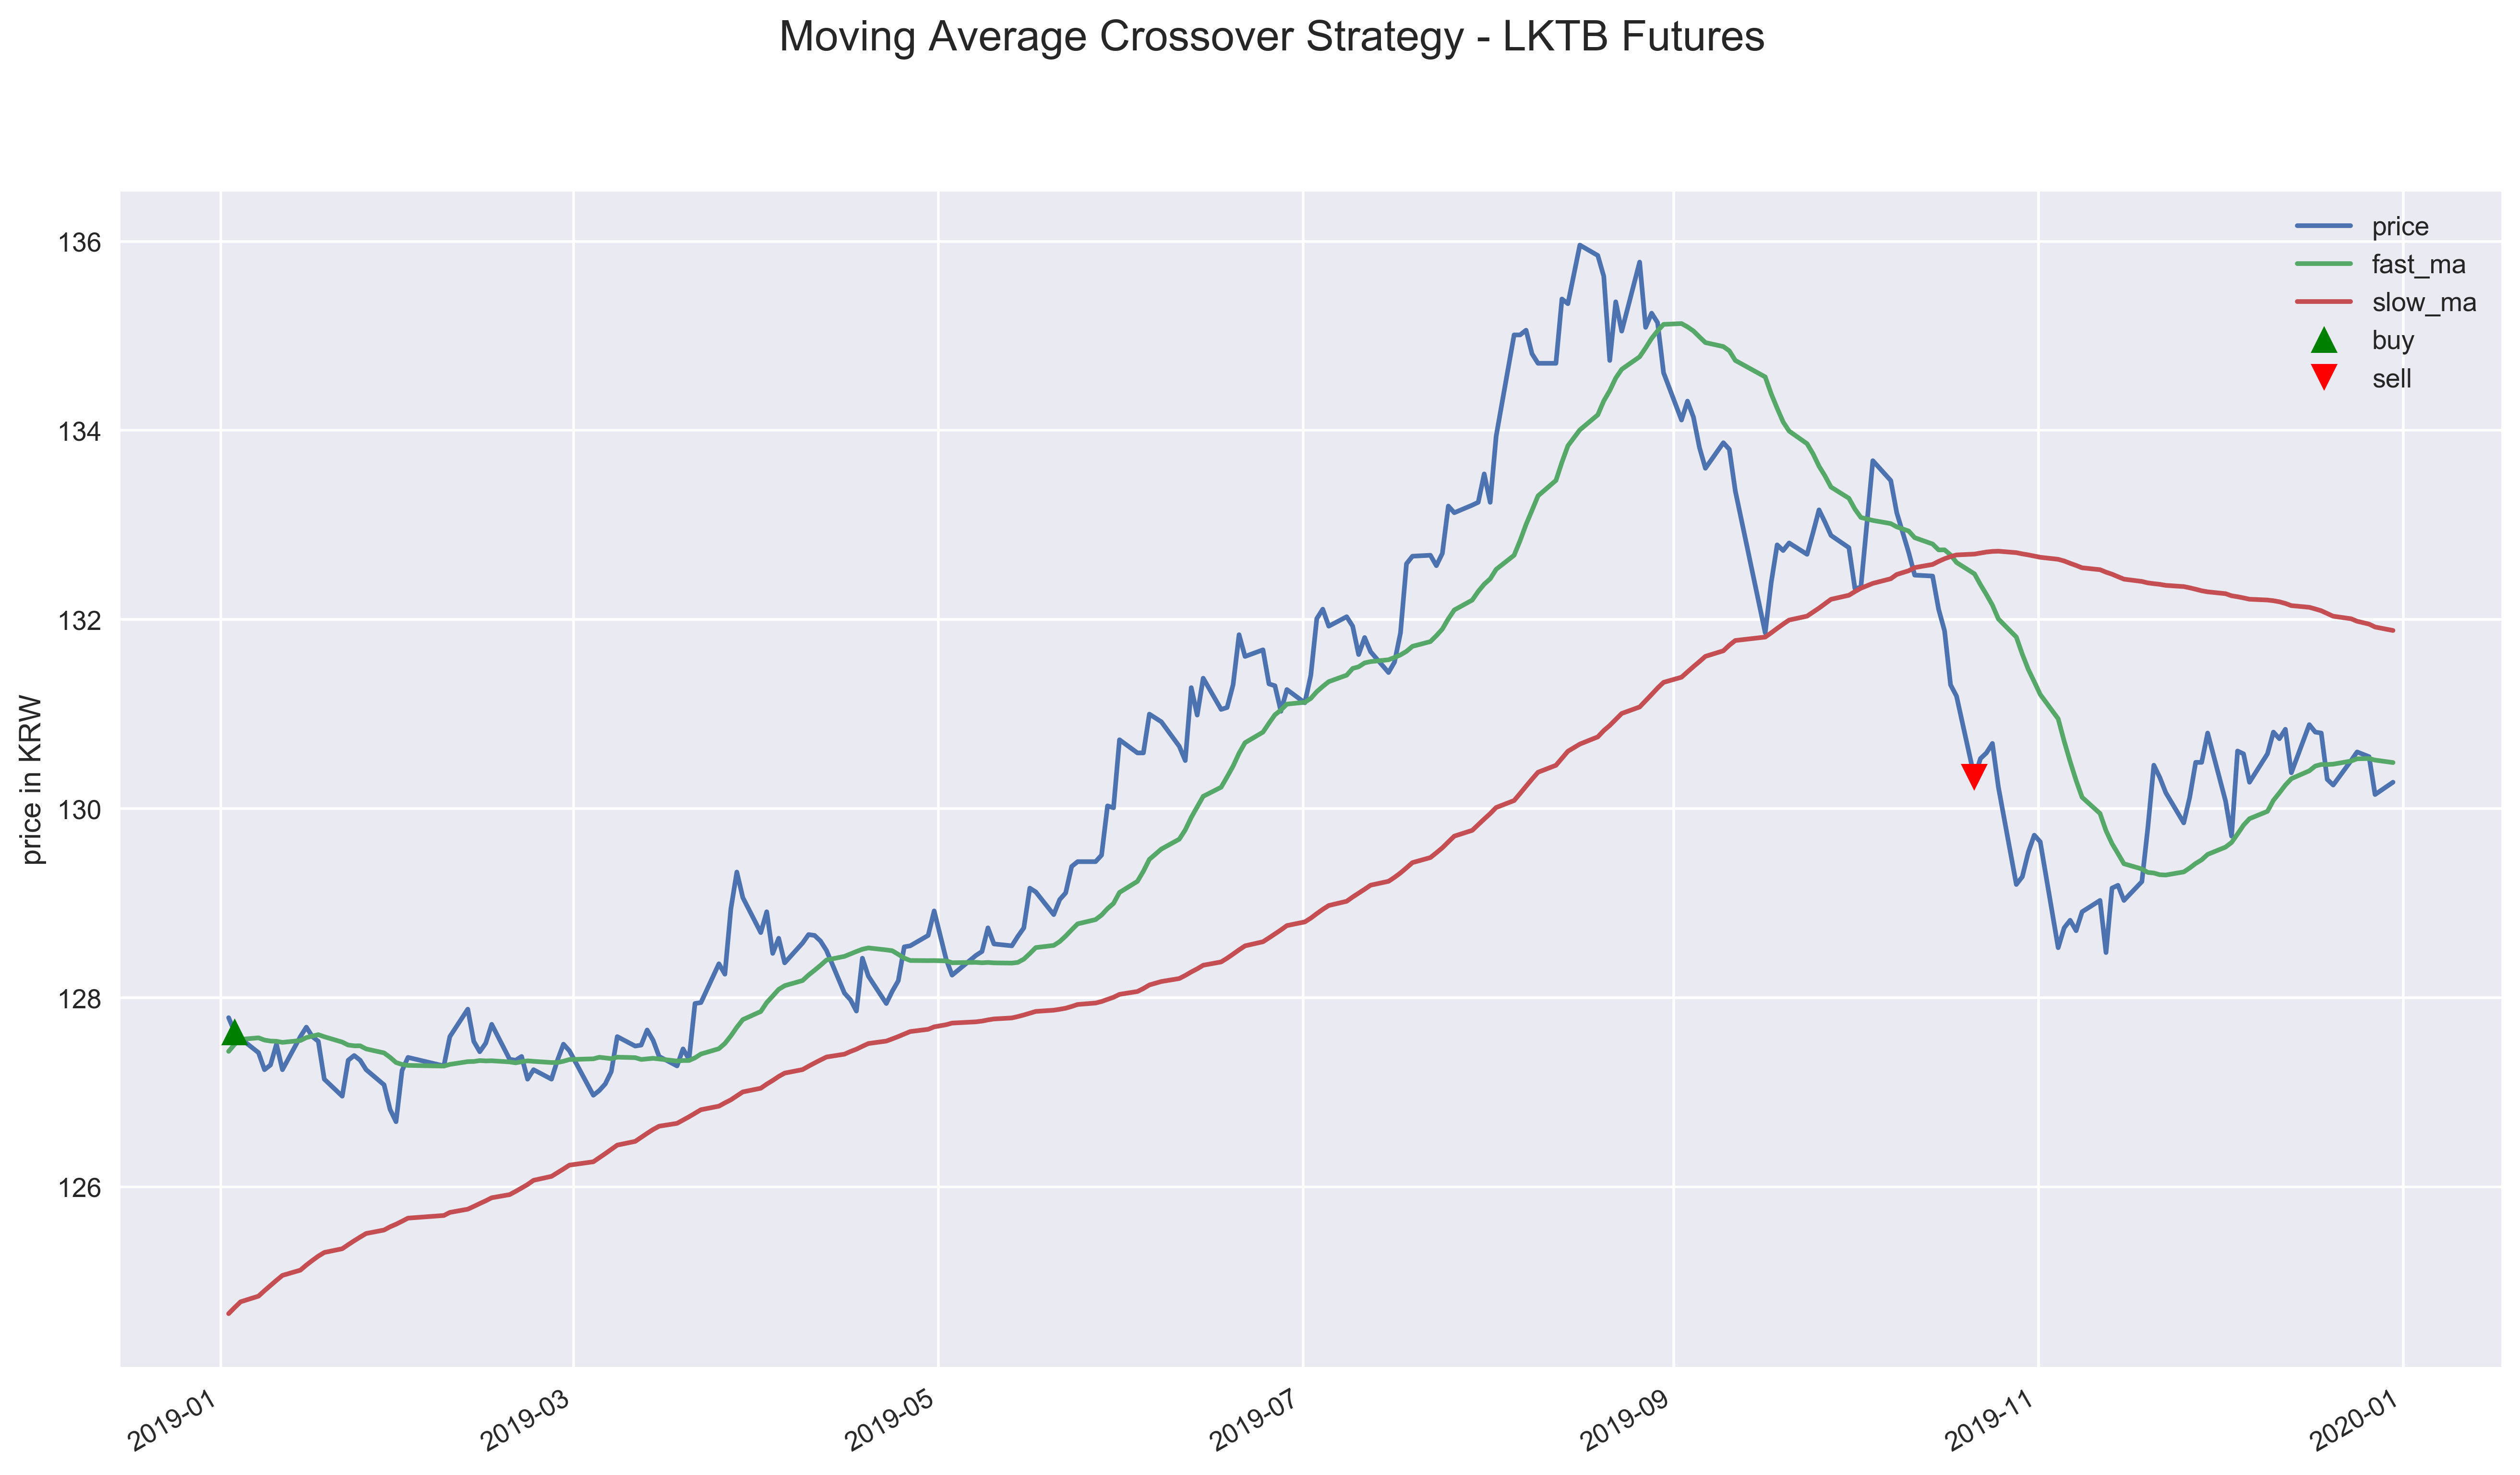

In [20]:
fig, ax = plt.subplots()

# asset
mac_results[['price', 'fast_ma', 'slow_ma']].plot(ax=ax)
ax.set_ylabel('price in KRW')

# mark transactions
perf_trans = mac_results.loc[[t != [] for t in mac_results.transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
ax.plot(buys.index, mac_results.price.loc[buys.index], '^', markersize=10, color='g', label='buy')
ax.plot(sells.index, mac_results.price.loc[sells.index], 'v', markersize=10, color='r', label='sell')
ax.legend()

fig.suptitle('Moving Average Crossover Strategy - LKTB Futures', fontsize=16)
plt.legend()
plt.show()

In [21]:
mac_perf = qf.get_performance_summary(mac_results.returns)

### MACD

In [22]:
%%zipline --start 2019-1-2 --end 2019-12-30 --capital-base 10000 --bundle krx_futures -o macd.pkl --trading-calendar XKRX

# imports ----
from zipline.api import order_target, record, symbol, set_commission, order_percent
import matplotlib.pyplot as plt
import talib as ta
from zipline.finance import commission

# parameters ----
SELECTED_STOCK = 'LKTB'

 #initialize the strategy 
def initialize(context):
    context.asset = symbol(SELECTED_STOCK)
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.has_position = False
    
def handle_data(context, data):
    
    price_history = data.history(context.asset, fields="price", bar_count=34, frequency="1d")
    macd, macdsignal, macdhist = ta.MACD(price_history, 12, 26, 9) 
    
    if (macdsignal[-1] < macd[-1]) and (not context.has_position):
        order_percent(context.asset, 1.0)
        context.has_position = True
        
    if (macdsignal[-1] > macd[-1]) and (context.has_position):
        order_target(context.asset, 0)
        context.has_position = False
        
    record(macd =  macd[-1], macdsignal = macdsignal[-1], macdhist = macdhist[-1], price=price_history[-1]) 

C:\ProgramData\Anaconda3\envs\backtest\lib\site-packages\empyrical\stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
C:\ProgramData\Anaconda3\envs\backtest\lib\site-packages\empyrical\stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


algo_volatility  algorithm_period_return alpha  \
2019-01-02 06:30:00+00:00              NaN                 0.000000  None   
2019-01-03 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-04 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-07 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-08 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-09 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-10 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-11 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-14 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-15 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-16 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-17 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-18 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-21 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-22 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-23 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-24 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-25 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-28 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-29 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-30 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-31 06:30:00+00:00         0.000000                 0.000000  None   
2019-02-01 06:30:00+00:00         0.000000                 0.000000  None   
2019-02-07 06:30:00+00:00         0.000000                 0.000000  None   
2019-02-08 06:30:00+00:00         0.001580                -0.000498  None   
2019-02-11 06:30:00+00:00         0.007274                 0.001764  None   
2019-02-12 06:30:00+00:00         0.010940                -0.000888  None   
2019-02-13 06:30:00+00:00         0.011018                -0.001746  None   
2019-02-14 06:30:00+00:00         0.011052                -0.001044  None   
2019-02-15 06:30:00+00:00         0.011806                 0.000516  None   
...                                    ...                      ...   ...   
2019-11-18 06:30:00+00:00         0.029437                 0.023958  None   
2019-11-19 06:30:00+00:00         0.029730                 0.028469  None   
2019-11-20 06:30:00+00:00         0.030131                 0.033683  None   
2019-11-21 06:30:00+00:00         0.030087                 0.032656  None   
2019-11-22 06:30:00+00:00         0.030055                 0.031384  None   
2019-11-25 06:30:00+00:00         0.030113                 0.028864  None   
2019-11-26 06:30:00+00:00         0.030116                 0.030997  None   
2019-11-27 06:30:00+00:00         0.030184                 0.033920  None   
2019-11-28 06:30:00+00:00         0.030117                 0.033920  None   
2019-11-29 06:30:00+00:00         0.030141                 0.036369  None   
2019-12-02 06:30:00+00:00         0.030658                 0.030681  None   
2019-12-03 06:30:00+00:00         0.030749                 0.027758  None   
2019-12-04 06:30:00+00:00         0.031499                 0.034868  None   
2019-12-05 06:30:00+00:00         0.031433                 0.034631  None   
2019-12-06 06:30:00+00:00         0.031468                 0.032261  None   
2019-12-09 06:30:00+00:00         0.031480                 0.034631  None   
2019-12-10 06:30:00+00:00         0.031457                 0.036448  None   
2019-12-11 06:30:00+00:00         0.031397                 0.035895  None   
2019-12-12 06:30:00+00:00         0.031336                 0.036685  None   
2019-12-13 06:30:00+00:00         0.031563                 0.032536  None   
2019-12-16 06:30:00+00:

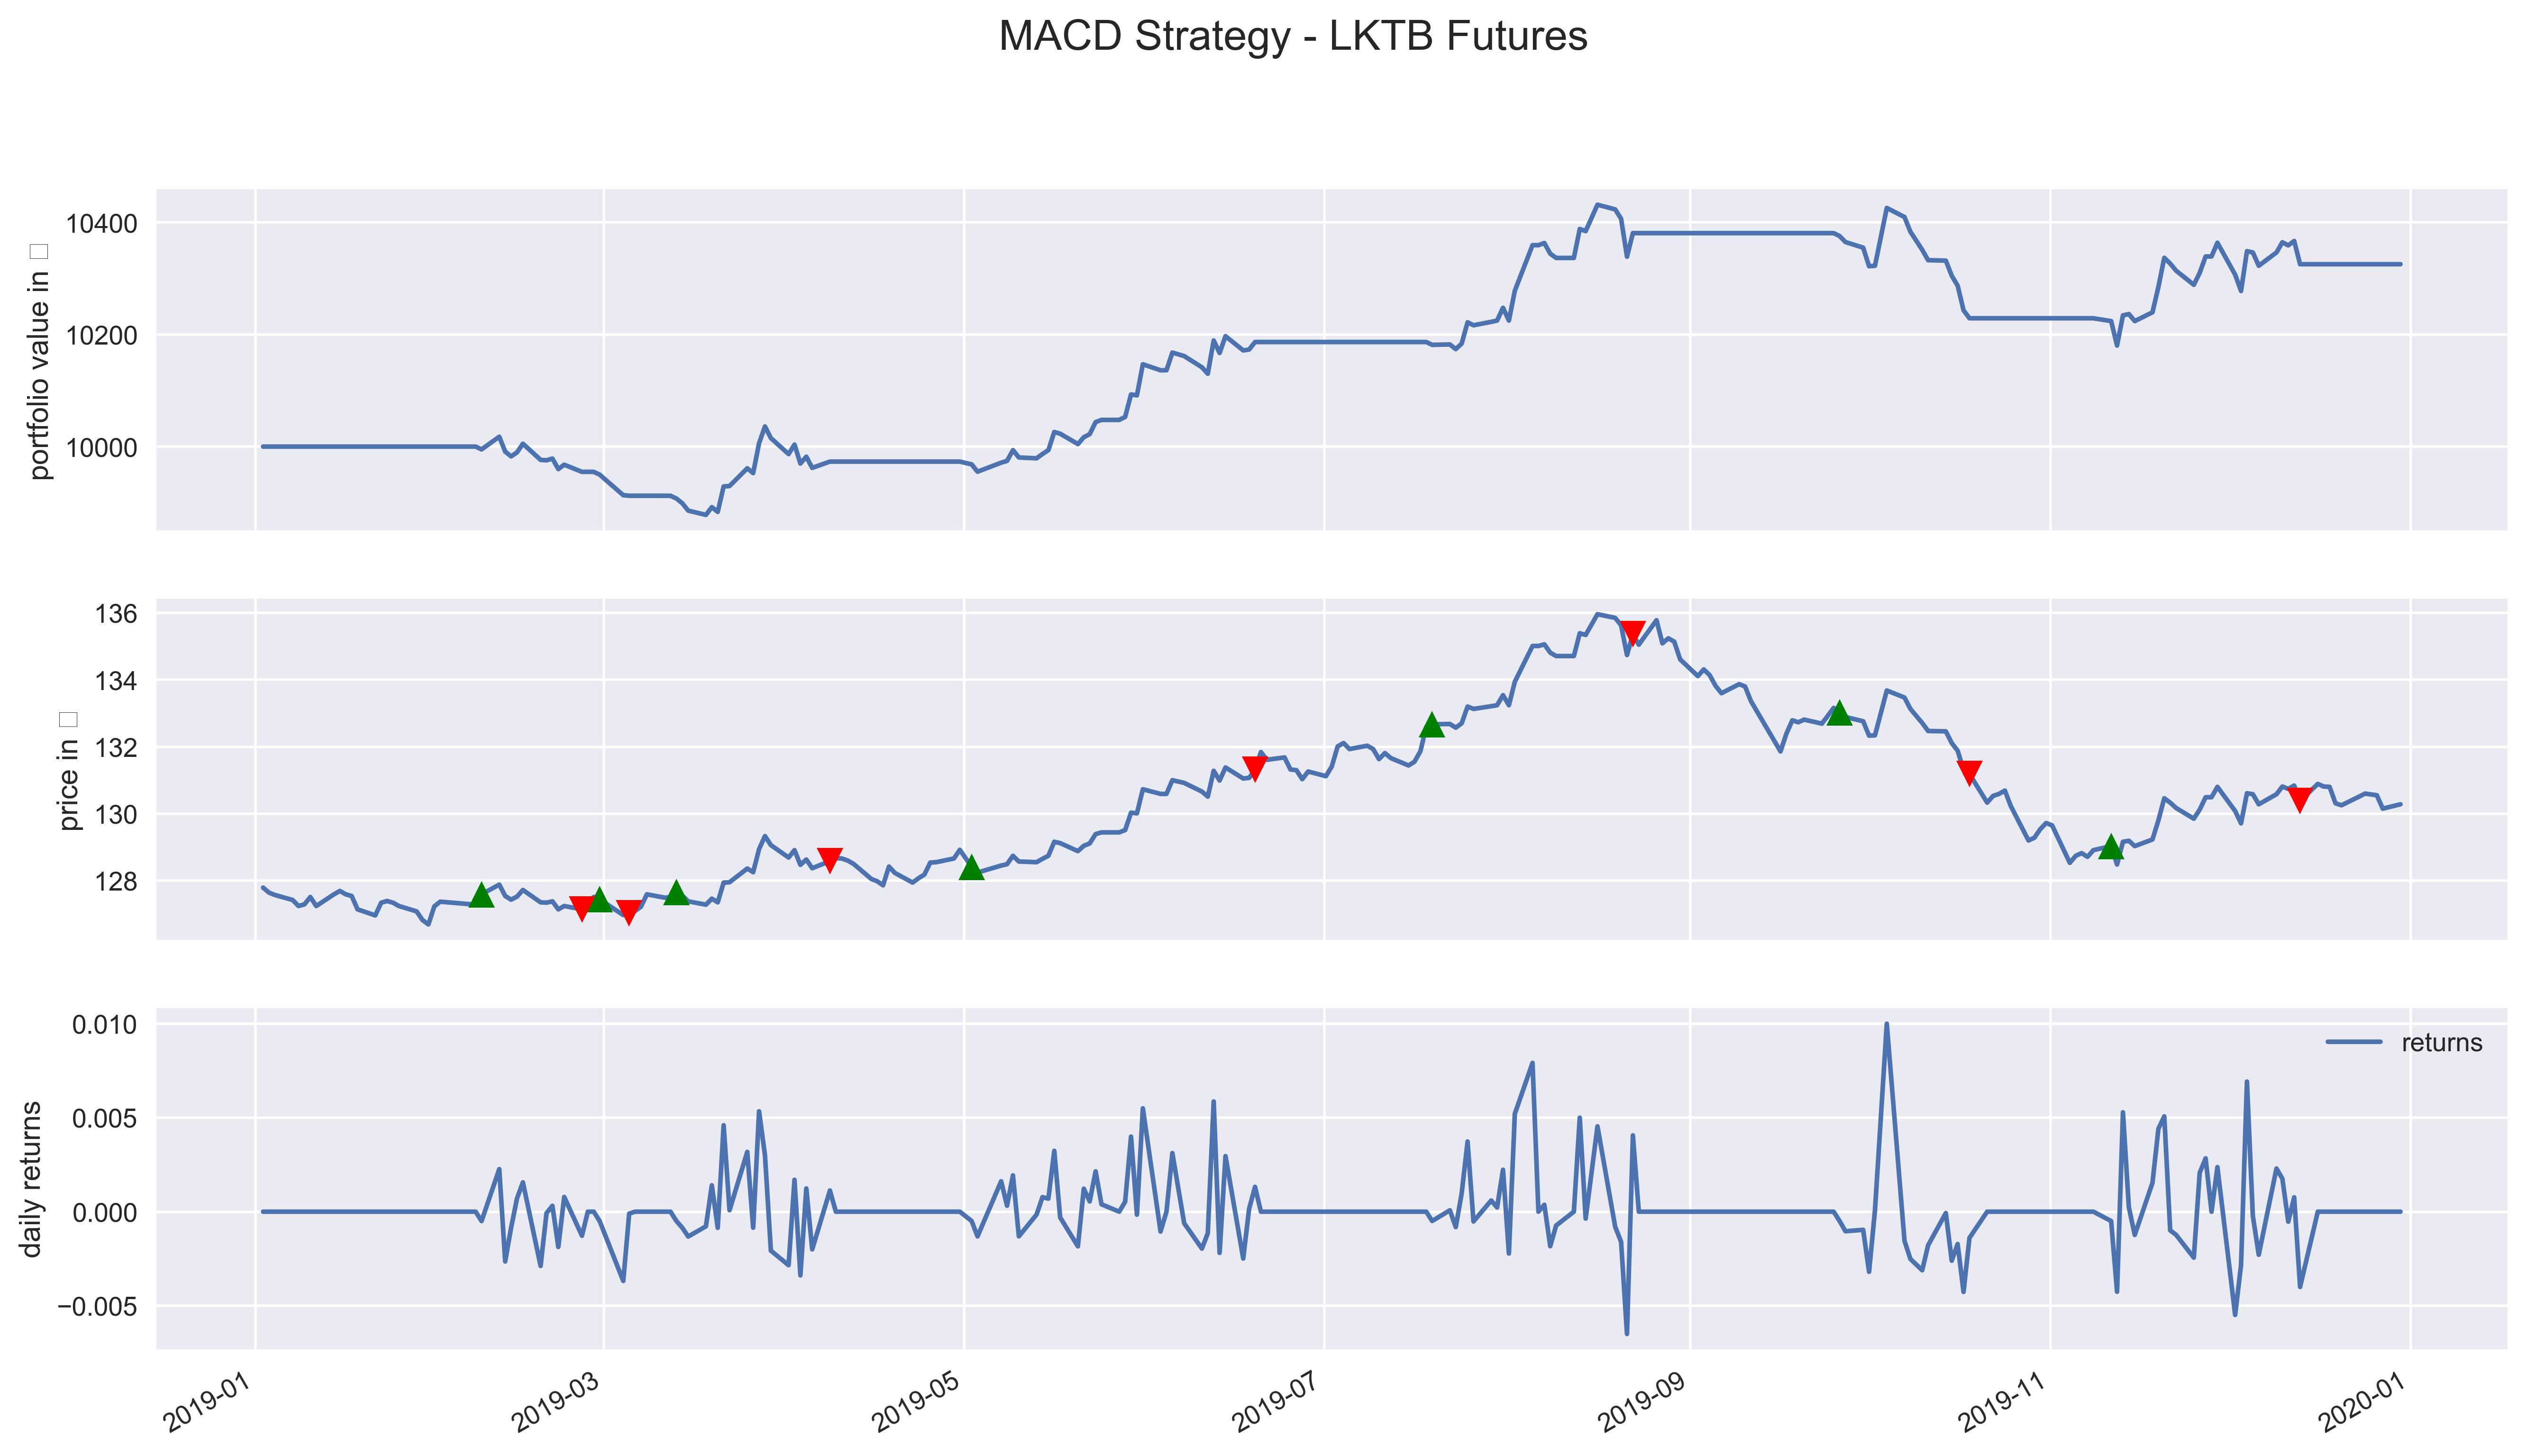

Final portfolio value (including cash): 10325.36￦


In [23]:
macd_results = pd.read_pickle('macd.pkl')
qf.visualize_results(macd_results, 'MACD Strategy - LKTB Futures', '￦')

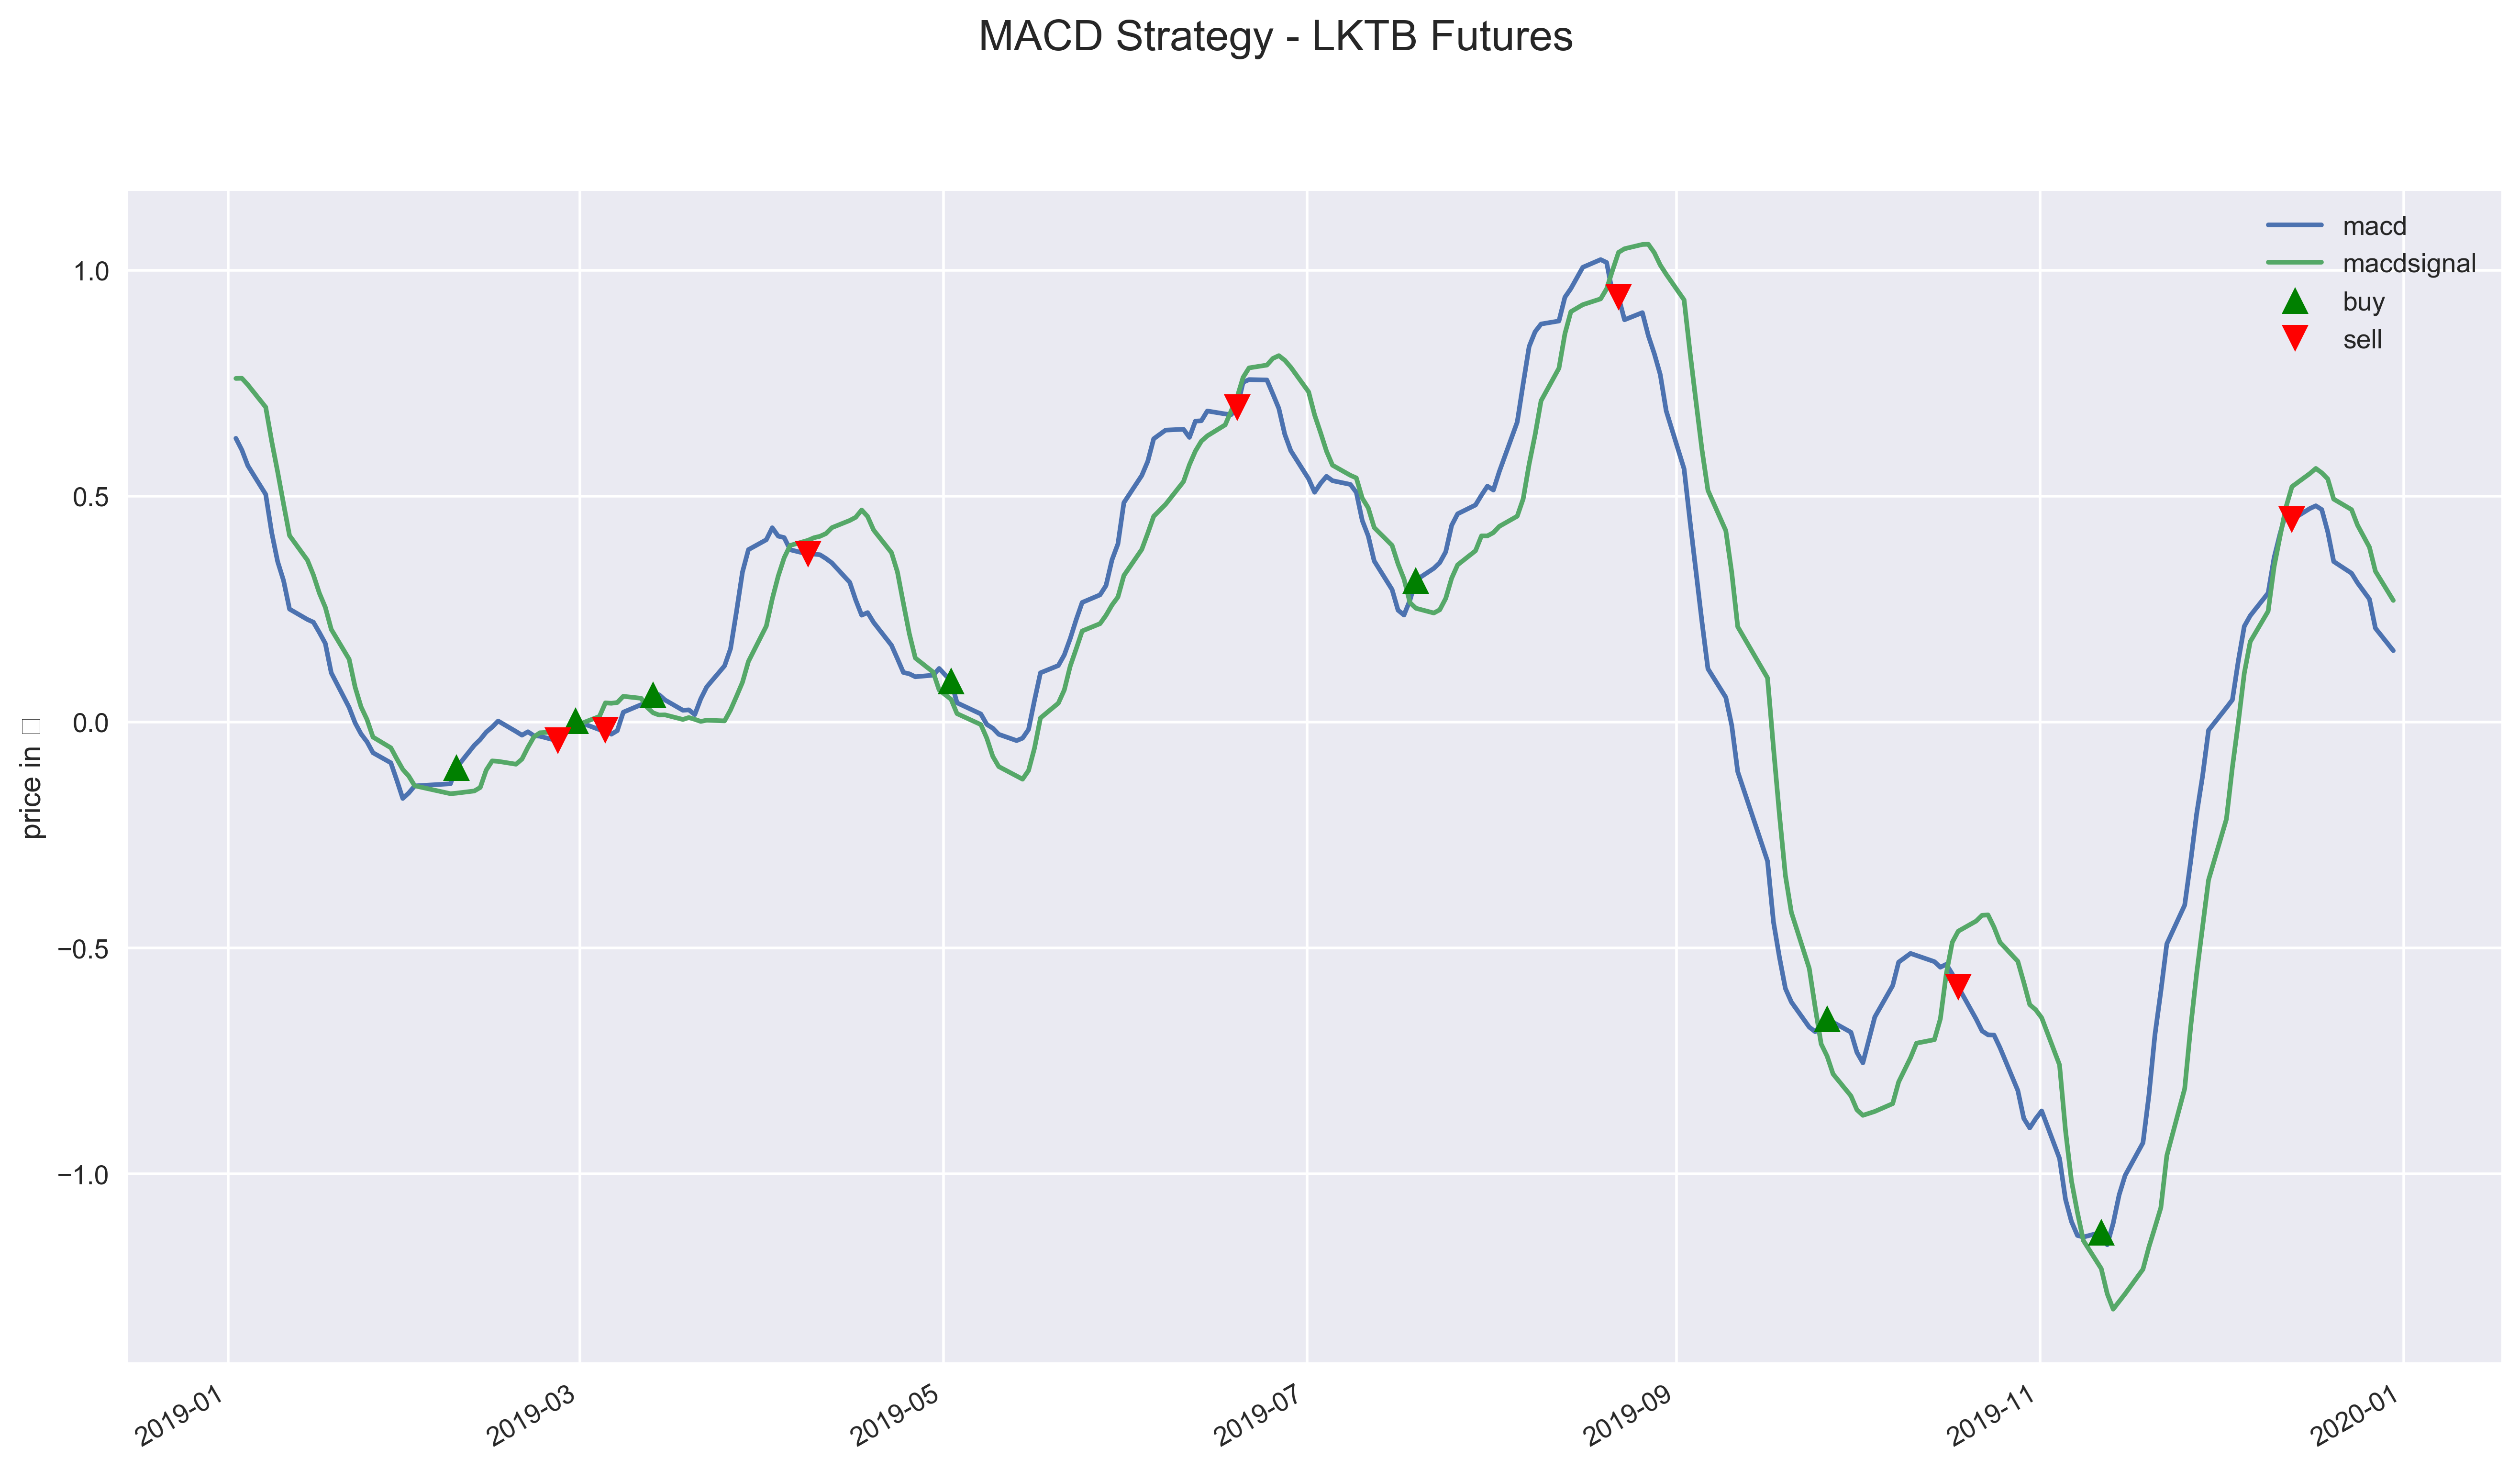

In [24]:
fig, ax = plt.subplots()

# asset
macd_results[['macd', 'macdsignal']].plot(ax=ax)
ax.set_ylabel('price in ￦')

# mark transactions
perf_trans = macd_results.loc[[t != [] for t in macd_results.transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
ax.plot(buys.index, macd_results.macd.loc[buys.index], '^', markersize=10, color='g', label='buy')
ax.plot(sells.index, macd_results.macd.loc[sells.index], 'v', markersize=10, color='r', label='sell')
ax.legend()

fig.suptitle('MACD Strategy - LKTB Futures', fontsize=16)
plt.show()

In [25]:
macd_perf = qf.get_performance_summary(macd_results.returns)

### RSI

In [26]:
%%zipline --start 2019-1-2 --end 2019-12-30 --capital-base 10000 --bundle krx_futures -o rsi.pkl --trading-calendar XKRX

# imports ----
from zipline.api import order_target, record, symbol, set_commission, order_percent
import matplotlib.pyplot as plt
import talib as ta
from zipline.finance import commission

# parameters ----
SELECTED_STOCK = 'LKTB'
UPPER = 70
LOWER = 30
RSI_PERIOD = 14

#initialize the strategy 
def initialize(context):
    context.asset = symbol(SELECTED_STOCK)
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.has_position = False
    
def handle_data(context, data):
    
    price_history = data.history(context.asset, fields="price", bar_count=RSI_PERIOD+1, frequency="1d")
    rsi = ta.RSI(price_history, timeperiod=RSI_PERIOD)
    
    if rsi[-1] < LOWER and not context.has_position:
        order_percent(context.asset, 1.0)
        context.has_position = True
      
    if rsi[-1] > UPPER and context.has_position:
        order_target(context.asset, 0)
        context.has_position = False
     
    record(rsi=rsi[-1], price=price_history[-1]) 

C:\ProgramData\Anaconda3\envs\backtest\lib\site-packages\empyrical\stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
C:\ProgramData\Anaconda3\envs\backtest\lib\site-packages\empyrical\stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


algo_volatility  algorithm_period_return alpha  \
2019-01-02 06:30:00+00:00              NaN                 0.000000  None   
2019-01-03 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-04 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-07 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-08 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-09 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-10 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-11 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-14 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-15 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-16 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-17 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-18 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-21 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-22 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-23 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-24 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-25 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-28 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-29 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-30 06:30:00+00:00         0.000000                 0.000000  None   
2019-01-31 06:30:00+00:00         0.000000                 0.000000  None   
2019-02-01 06:30:00+00:00         0.000000                 0.000000  None   
2019-02-07 06:30:00+00:00         0.000000                 0.000000  None   
2019-02-08 06:30:00+00:00         0.000000                 0.000000  None   
2019-02-11 06:30:00+00:00         0.000000                 0.000000  None   
2019-02-12 06:30:00+00:00         0.000000                 0.000000  None   
2019-02-13 06:30:00+00:00         0.000000                 0.000000  None   
2019-02-14 06:30:00+00:00         0.000000                 0.000000  None   
2019-02-15 06:30:00+00:00         0.000000                 0.000000  None   
...                                    ...                      ...   ...   
2019-11-18 06:30:00+00:00         0.024478                -0.013269  None   
2019-11-19 06:30:00+00:00         0.024876                -0.008986  None   
2019-11-20 06:30:00+00:00         0.025399                -0.004036  None   
2019-11-21 06:30:00+00:00         0.025362                -0.005011  None   
2019-11-22 06:30:00+00:00         0.025337                -0.006219  None   
2019-11-25 06:30:00+00:00         0.025464                -0.009098  None   
2019-11-26 06:30:00+00:00         0.025406                -0.009098  None   
2019-11-27 06:30:00+00:00         0.025349                -0.009098  None   
2019-11-28 06:30:00+00:00         0.025293                -0.009098  None   
2019-11-29 06:30:00+00:00         0.025236                -0.009098  None   
2019-12-02 06:30:00+00:00         0.025180                -0.009098  None   
2019-12-03 06:30:00+00:00         0.025125                -0.009098  None   
2019-12-04 06:30:00+00:00         0.025070                -0.009098  None   
2019-12-05 06:30:00+00:00         0.025015                -0.009098  None   
2019-12-06 06:30:00+00:00         0.024961                -0.009098  None   
2019-12-09 06:30:00+00:00         0.024907                -0.009098  None   
2019-12-10 06:30:00+00:00         0.024853                -0.009098  None   
2019-12-11 06:30:00+00:00         0.024800                -0.009098  None   
2019-12-12 06:30:00+00:00         0.024747                -0.009098  None   
2019-12-13 06:30:00+00:00         0.024694                -0.009098  None   
2019-12-16 06:30:00+00:

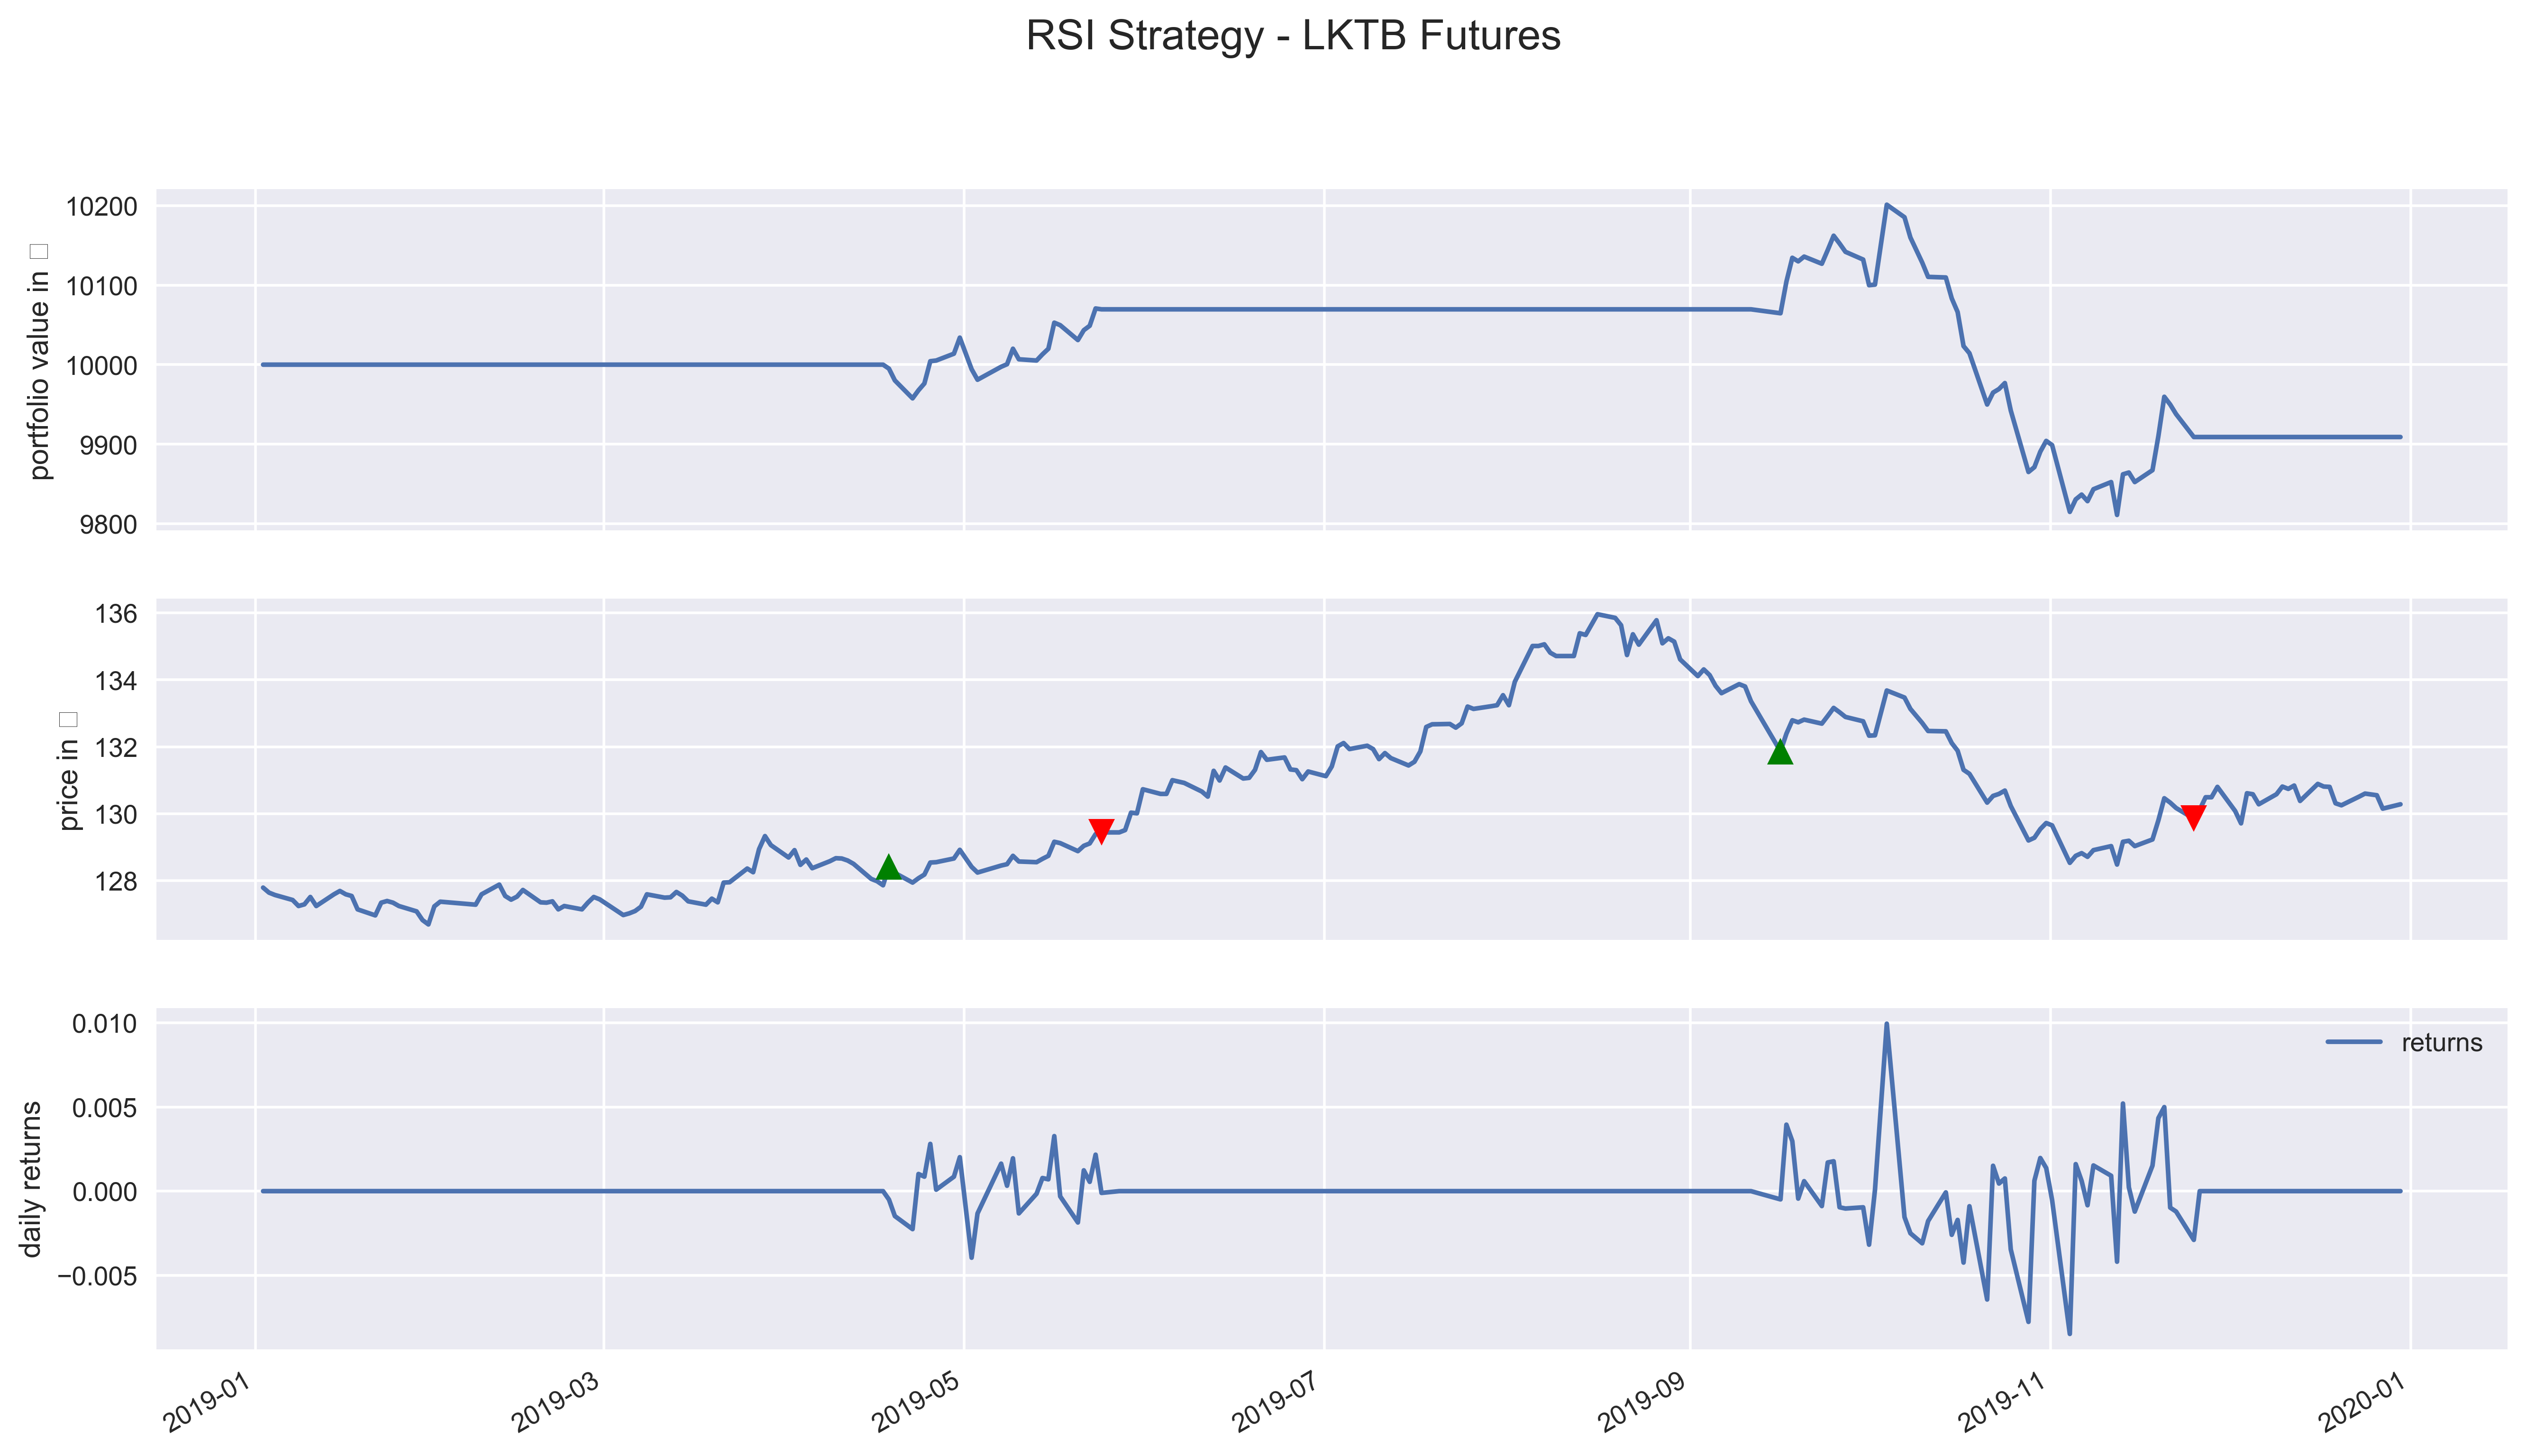

Final portfolio value (including cash): 9909.02￦


In [27]:
rsi_results = pd.read_pickle('rsi.pkl')
qf.visualize_results(rsi_results, 'RSI Strategy - LKTB Futures', '￦')

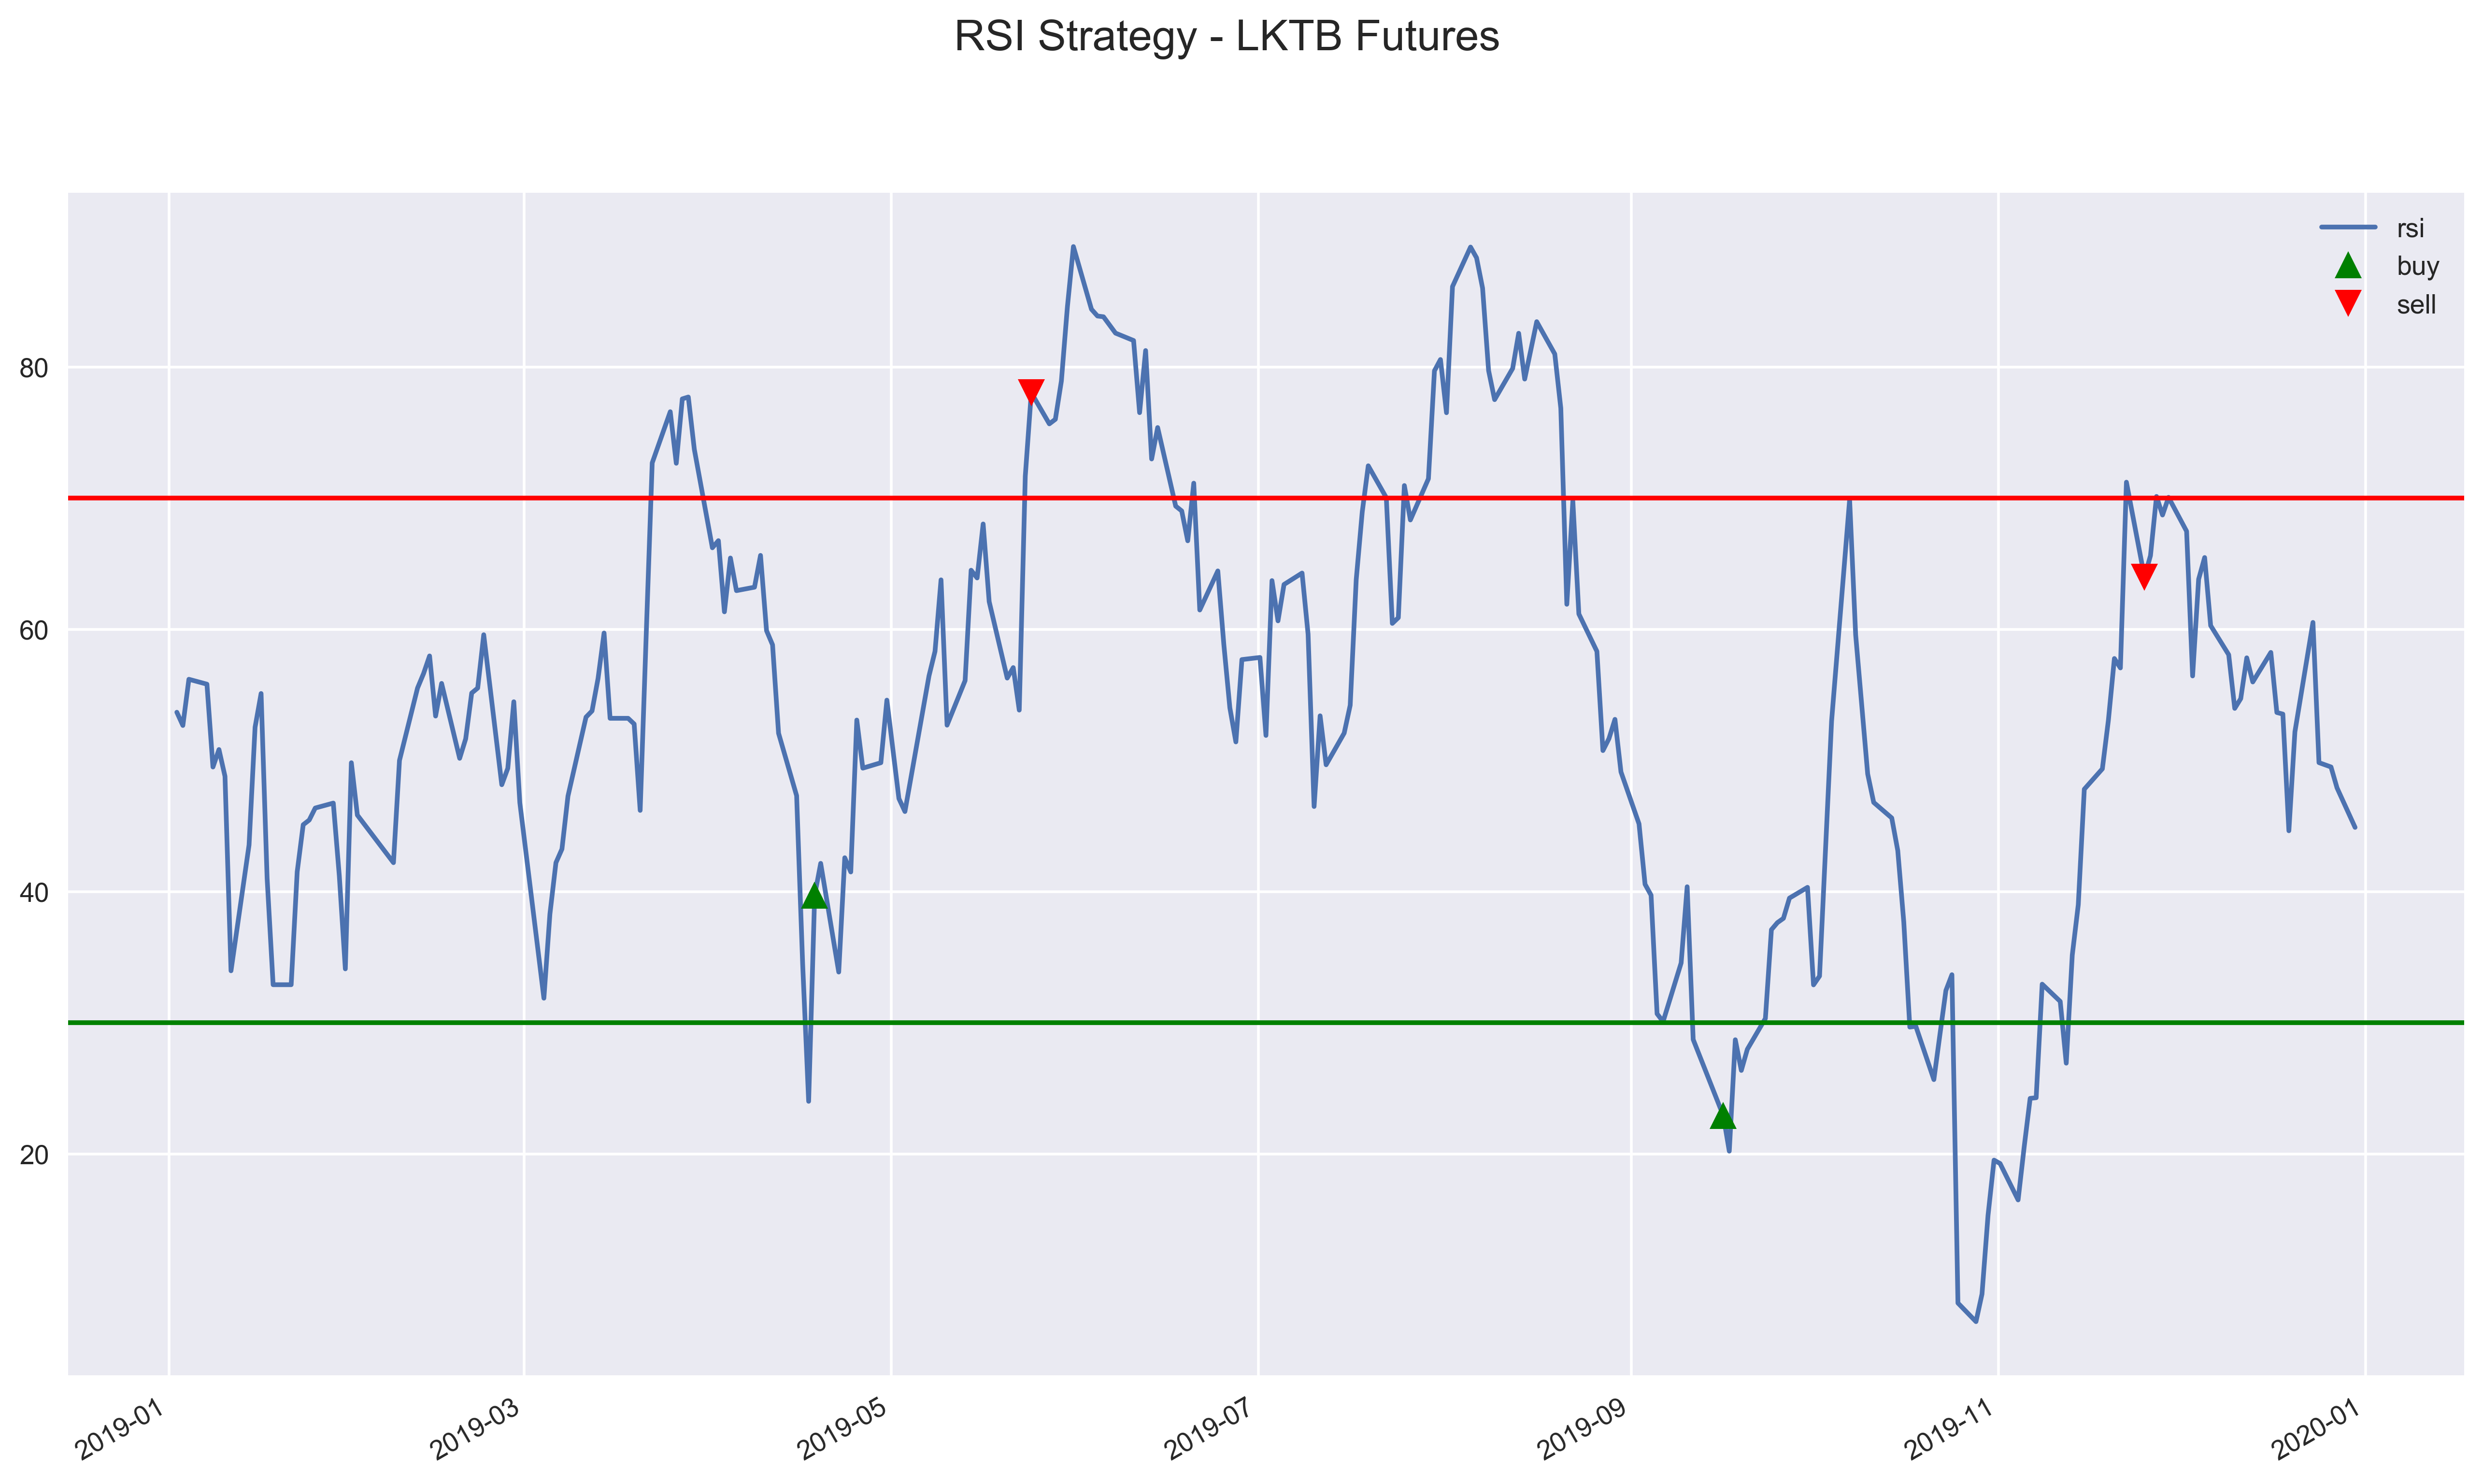

In [28]:
#fig, ax = plt.subplots(1, 1, sharex=True, figsize=[16, 9])
fig, ax = plt.subplots()

# asset
rsi_results[['rsi']].plot(ax=ax)
ax.axhline(y=70, color='r')
ax.axhline(y=30, color='g')

# mark transactions
perf_trans = rsi_results.loc[[t != [] for t in rsi_results.transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
ax.plot(buys.index, rsi_results.rsi.loc[buys.index], '^', markersize=10, color='g', label='buy')
ax.plot(sells.index, rsi_results.rsi.loc[sells.index], 'v', markersize=10, color='r', label='sell')
ax.legend()

fig.suptitle('RSI Strategy - LKTB Futures', fontsize=16)
plt.show()

In [29]:
rsi_perf = qf.get_performance_summary(rsi_results.returns)

## Evaluating the performance

In [30]:
perf_df = pd.DataFrame({'Buy and Hold': buy_and_hold_perf,
                        'Simple Moving Average': sma_perf,
                        'Moving Average Crossover': mac_perf,
                        'MACD': macd_perf,
                        'RSI': rsi_perf})
perf_df.transpose()

annual_volatility  annualized_returns  \
Buy and Hold                       0.042328            0.020589   
MACD                               0.030915            0.033343   
Moving Average Crossover           0.036637            0.020468   
RSI                                0.024185           -0.009319   
Simple Moving Average              0.030914            0.005570   

                          cumulative_returns  max_drawdown  sharpe_ratio  \
Buy and Hold                        0.020094     -0.054821      0.502581   
MACD                                0.032536     -0.024083      1.076367   
Moving Average Crossover            0.019976     -0.041735      0.571287   
RSI                                -0.009098     -0.038238     -0.375081   
Simple Moving Average               0.005437     -0.028770      0.195056   

                          sortino_ratio  
Buy and Hold                   0.736697  
MACD                           1.896105  
Moving Average Crossover       0.871363  
RSI                           -0.507992  
Simple Moving Average          0.305036